# Analyzing Complaints to the NYPD With a Focus on Crime in the Subway System
## Danielle Shelton
#### CS668 Analytics Capstone Project Spring 2024

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data

New York City is the most populated city in the United States:
- 8.34 million residents, April 2022.
- Appr. 1 million commuters daily.
- Largest police department: 36000 officers, 19000 civilian employees.

From 2006 to 2022, there were 8.36 million complaints filed with the NYPD. These complaints include felonies, misdemeanors, and violations that take place across all 5 boroughs in homes, places of worship, on city streets, and in the subways. NYC Open Data has detailed documentation of these complaints allowing anyone to gain a better understanding of crime patterns over time, location, and demographics. For this project, I chose to focus on complaints of crime committed exclusively within subway stations. Due to this, the borough of Staten Island is not included in this research project. Querying the data by Station Name and Borough the initial dataset of 8.36 million complaints was paired down to 182,959 complaints.

#### Import Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import datetime

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools

pd.pandas.set_option('display.max_columns', None)
color_pal = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data/updated_NYPD_Complaint_Data_Historic.csv')

In [3]:
data.head()

COMPLAINT_ID COMPLAINT_DATE COMPLAINT_TIME CMPLNT_TO_DT CMPLNT_TO_TM  \
0      23320709     2006-01-01       12:01 AM     7/3/2006     23:59:00   
1      13736560     2006-01-01        7:00 PM    5/10/2006     14:00:00   
2       9935387     2006-01-01        1:00 AM     1/1/2006      3:00:00   
3       9932532     2006-01-01        5:20 AM          NaN       (null)   
4      10155213     2006-01-01        7:30 AM          NaN       (null)   

   ADDR_PCT_CD REPORT_DATE  KY_CD                       OFNS_DESC  PD_CD  \
0        104.0  2006-07-06    121  CRIMINAL MISCHIEF & RELATED OF    269   
1         62.0  2006-05-10    351  CRIMINAL MISCHIEF & RELATED OF    258   
2         61.0  2006-01-01    341                   PETIT LARCENY    339   
3        115.0  2006-01-01    109                   GRAND LARCENY    419   
4          9.0  2006-01-01    109                   GRAND LARCENY    415   

                          PD_DESC CRIME_ATTEMPT  OFFENSE_LVL    BOROUGH  \
0  MISCHIEF,CRIMINAL,    UNCL 2ND     COMPLETED       FELONY     QUEENS   
1  CRIMINAL MISCHIEF 4TH, GRAFFIT     COMPLETED  MISDEMEANOR   BROOKLYN   
2  LARCENY,PETIT FROM OPEN AREAS,     COMPLETED  MISDEMEANOR   BROOKLYN   
3  LARCENY,GRAND FROM PERSON,UNCL     COMPLETED       FELONY     QUEENS   
4  LARCENY,GRAND FROM PERSON,PICK     COMPLETED       FELONY  MANHATTAN   

  LOC_OF_OCCUR_DESC         PREM_TYP_DESC           JURIS_DESC  JURIS_CODE  \
0            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
1            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
2            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
3            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
4            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   

  PARKS_NM HADEVELOPT HOUSING_PSA    X_COORD   Y_COORD SUSP_AGE SUSP_RACE  \
0   (null)     (null)      (null)  1010686.0  192838.0   (null)    (null)   
1   (null)     (null)      (null)   988511.0  164316.0   (null)    (null)   
2   (null)     (null)      (null)   996967.0  153279.0    18-24     WHITE   
3   (null)     (null)      (null)  1014333.0  211391.0   (null)     BLACK   
4   (null)     (null)      (null)   986624.0  205185.0   (null)    (null)   

  SUSP_SEX  TRANSIT_DISTRICT   Latitude  Longitude  \
0   (null)                33  40.695933 -73.904666   
1   (null)                34  40.617685 -73.984652   
2        M                34  40.587382 -73.954214   
3        M                20  40.746845 -73.891431   
4   (null)                 4  40.729862 -73.991434   

                       Lat_Lon               PATROL_BORO     STATION_NAME  \
0  (40.69593301, -73.90466563)  PATROL BORO QUEENS NORTH    HALSEY STREET   
1  (40.61768484, -73.98465185)   PATROL BORO BKLYN SOUTH        59 STREET   
2  (40.58738242, -73.95421409)   PATROL BORO BKLYN SOUTH   SHEEPSHEAD BAY   
3  (40.74684483, -73.89143078)  PATROL BORO QUEENS NORTH  74 ST.-BROADWAY   
4  (40.72986175, -73.99143444)     PATROL BORO MAN SOUTH      ASTOR PLACE   

  VIC_AGE VIC_RACE VIC_SEX  Zip Code  Comm_Dist  Boro_Boundary  \
0  (null)  UNKNOWN       D   15310.0       42.0            3.0   
1  (null)  UNKNOWN       D   16867.0        1.0            2.0   
2   18-24    WHITE       F   13826.0       32.0            2.0   
3   18-24    WHITE       M   14784.0       65.0            3.0   
4   18-24    BLACK       M   11724.0       57.0            4.0   

   City_Council_Dist  Police_Precinct  
0               37.0             53.0  
1               45.0             37.0  
2               15.0             36.0  
3                5.0             73.0  
4               50.0              5.0

In [4]:
data.shape

(182959, 40)

#### Combine Complaint Date and Complaint Time

In [5]:
data['DATETIME'] = pd.to_datetime(data['COMPLAINT_DATE'] + ' ' + data['COMPLAINT_TIME'])

#### Create second dataset that ends at the end of 2019, EXCLUDING COVID-19

In [6]:
data1 = data[data['DATETIME']<='2020-01-01']

In [7]:
data.head(5)

COMPLAINT_ID COMPLAINT_DATE COMPLAINT_TIME CMPLNT_TO_DT CMPLNT_TO_TM  \
0      23320709     2006-01-01       12:01 AM     7/3/2006     23:59:00   
1      13736560     2006-01-01        7:00 PM    5/10/2006     14:00:00   
2       9935387     2006-01-01        1:00 AM     1/1/2006      3:00:00   
3       9932532     2006-01-01        5:20 AM          NaN       (null)   
4      10155213     2006-01-01        7:30 AM          NaN       (null)   

   ADDR_PCT_CD REPORT_DATE  KY_CD                       OFNS_DESC  PD_CD  \
0        104.0  2006-07-06    121  CRIMINAL MISCHIEF & RELATED OF    269   
1         62.0  2006-05-10    351  CRIMINAL MISCHIEF & RELATED OF    258   
2         61.0  2006-01-01    341                   PETIT LARCENY    339   
3        115.0  2006-01-01    109                   GRAND LARCENY    419   
4          9.0  2006-01-01    109                   GRAND LARCENY    415   

                          PD_DESC CRIME_ATTEMPT  OFFENSE_LVL    BOROUGH  \
0  MISCHIEF,CRIMINAL,    UNCL 2ND     COMPLETED       FELONY     QUEENS   
1  CRIMINAL MISCHIEF 4TH, GRAFFIT     COMPLETED  MISDEMEANOR   BROOKLYN   
2  LARCENY,PETIT FROM OPEN AREAS,     COMPLETED  MISDEMEANOR   BROOKLYN   
3  LARCENY,GRAND FROM PERSON,UNCL     COMPLETED       FELONY     QUEENS   
4  LARCENY,GRAND FROM PERSON,PICK     COMPLETED       FELONY  MANHATTAN   

  LOC_OF_OCCUR_DESC         PREM_TYP_DESC           JURIS_DESC  JURIS_CODE  \
0            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
1            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
2            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
3            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   
4            (null)  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   

  PARKS_NM HADEVELOPT HOUSING_PSA    X_COORD   Y_COORD SUSP_AGE SUSP_RACE  \
0   (null)     (null)      (null)  1010686.0  192838.0   (null)    (null)   
1   (null)     (null)      (null)   988511.0  164316.0   (null)    (null)   
2   (null)     (null)      (null)   996967.0  153279.0    18-24     WHITE   
3   (null)     (null)      (null)  1014333.0  211391.0   (null)     BLACK   
4   (null)     (null)      (null)   986624.0  205185.0   (null)    (null)   

  SUSP_SEX  TRANSIT_DISTRICT   Latitude  Longitude  \
0   (null)                33  40.695933 -73.904666   
1   (null)                34  40.617685 -73.984652   
2        M                34  40.587382 -73.954214   
3        M                20  40.746845 -73.891431   
4   (null)                 4  40.729862 -73.991434   

                       Lat_Lon               PATROL_BORO     STATION_NAME  \
0  (40.69593301, -73.90466563)  PATROL BORO QUEENS NORTH    HALSEY STREET   
1  (40.61768484, -73.98465185)   PATROL BORO BKLYN SOUTH        59 STREET   
2  (40.58738242, -73.95421409)   PATROL BORO BKLYN SOUTH   SHEEPSHEAD BAY   
3  (40.74684483, -73.89143078)  PATROL BORO QUEENS NORTH  74 ST.-BROADWAY   
4  (40.72986175, -73.99143444)     PATROL BORO MAN SOUTH      ASTOR PLACE   

  VIC_AGE VIC_RACE VIC_SEX  Zip Code  Comm_Dist  Boro_Boundary  \
0  (null)  UNKNOWN       D   15310.0       42.0            3.0   
1  (null)  UNKNOWN       D   16867.0        1.0            2.0   
2   18-24    WHITE       F   13826.0       32.0            2.0   
3   18-24    WHITE       M   14784.0       65.0            3.0   
4   18-24    BLACK       M   11724.0       57.0            4.0   

   City_Council_Dist  Police_Precinct            DATETIME  
0               37.0             53.0 2006-01-01 00:01:00  
1               45.0             37.0 2006-01-01 19:00:00  
2               15.0             36.0 2006-01-01 01:00:00  
3                5.0             73.0 2006-01-01 05:20:00  
4               50.0              5.0 2006-01-01 07:30:00

In [8]:
data1['DATETIME'].max()

Timestamp('2019-12-31 23:45:00')

# Exploratory Data Analysis

- combine unknown and null values
- add outlier ages to the unknown values
- sort values alphabetically and numerically

In [9]:
data['SUSP_SEX'].replace(['U', '(null)'], 'UNKNOWN', inplace=True)
data['VIC_SEX'].replace(['D', 'E', 'L', '(null)'], 'UNKNOWN', inplace=True)
data['SUSP_RACE'].replace(['(null)'], 'UNKNOWN', inplace=True)
data['VIC_RACE'].replace(['(null)'], 'UNKNOWN', inplace=True)
data['SUSP_AGE'].replace(['(null)','505','165','32032','2013','2016','2017','1017','2019','2020','-971','2021','-6'], 'UNKNOWN', inplace=True)
data['VIC_AGE'].replace(['(null)','924','422','930','935','-939','-61','-73','-59','951'], 'UNKNOWN', inplace=True)

ss= data['SUSP_SEX'].sort_values()
sv= data['VIC_SEX'].sort_values()
rs= data['SUSP_RACE'].sort_values()
rv= data['VIC_RACE'].sort_values()
sa= data['SUSP_AGE'].sort_values()
va= data['VIC_AGE'].sort_values()
b = data['BOROUGH'].sort_values()
c = data['CRIME_ATTEMPT'].sort_values()

#### Data Visualization 

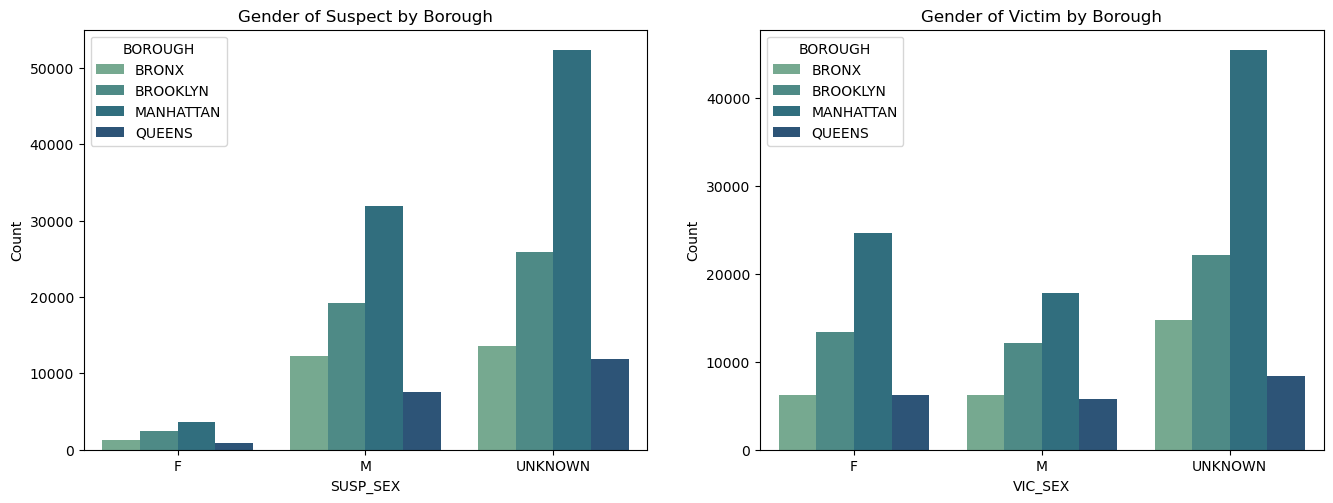

In [10]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
suspgender = sns.countplot(x=ss, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Gender of Suspect by Borough')
#plt.savefig('SuspectGender.png', bbox_inches='tight')

plt.subplot(2,2,2)
vicgender = sns.countplot(x=sv, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Gender of Victim by Borough')
#plt.savefig('VictimGender.png', bbox_inches='tight')

plt.show()

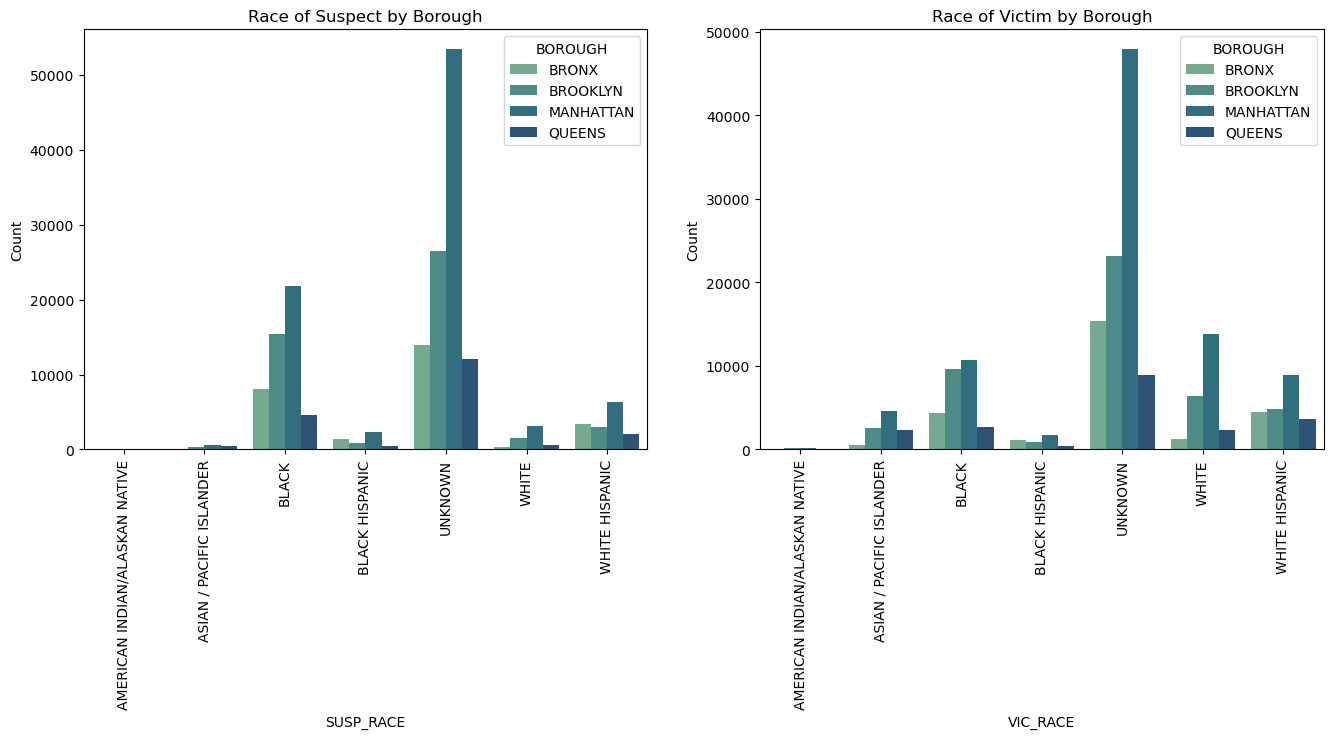

In [11]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
susprace = sns.countplot(x=rs, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Race of Suspect by Borough')
plt.xticks(rotation=90)
#plt.savefig('SuspectRace.png', bbox_inches='tight')


plt.subplot(2,2,2)
vicrace = sns.countplot(x=rv, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Race of Victim by Borough')
plt.xticks(rotation=90)
#plt.savefig('VictimRace.png', bbox_inches='tight')

plt.show()

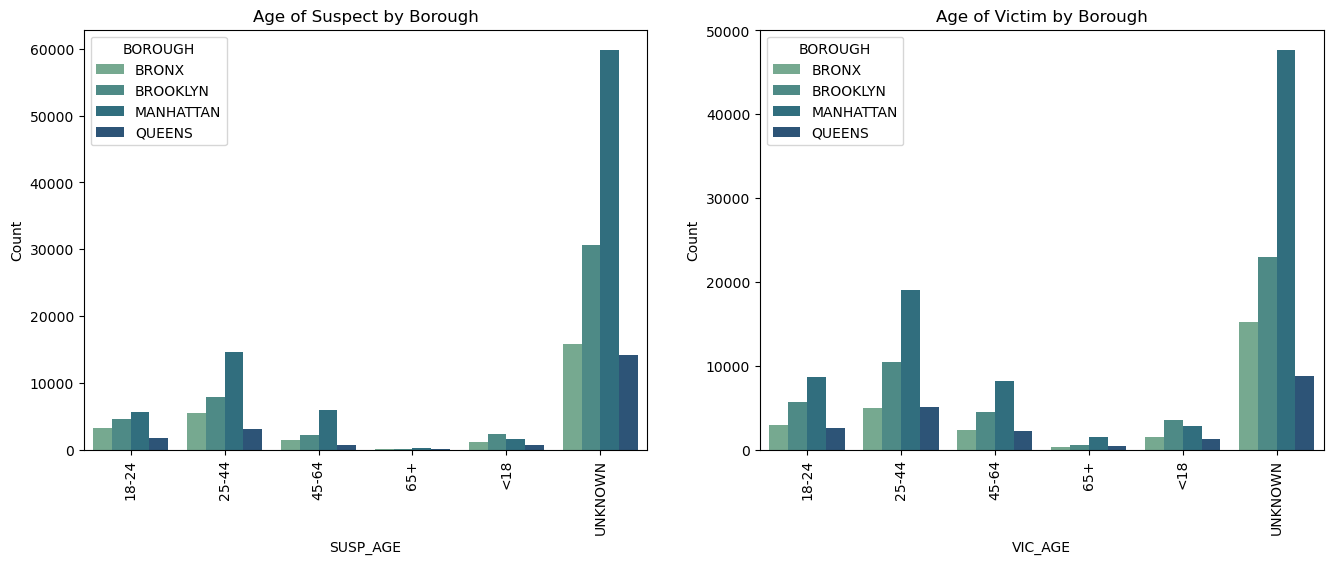

In [12]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
suspage = sns.countplot(x=sa, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Age of Suspect by Borough')
plt.xticks(rotation=90)
#plt.savefig('SuspectAge.png', bbox_inches='tight')

plt.subplot(2,2,2)
vicage = sns.countplot(x=va, hue=b, data=data, palette = 'crest')
plt.ylabel('Count')
plt.title('Age of Victim by Borough')
plt.xticks(rotation=90)
#plt.savefig('VictimAge.png', bbox_inches='tight')
plt.show()

Overwhelming majority of demographic data for suspects and victims is UNKNOWN. Due to this, it is not possible to perform analysis necessary to have an accurate understanding of victims and alleged suspects of crimes committed in subway stations throughout the Bronx, Brooklyn, Manhattan and Queens. 

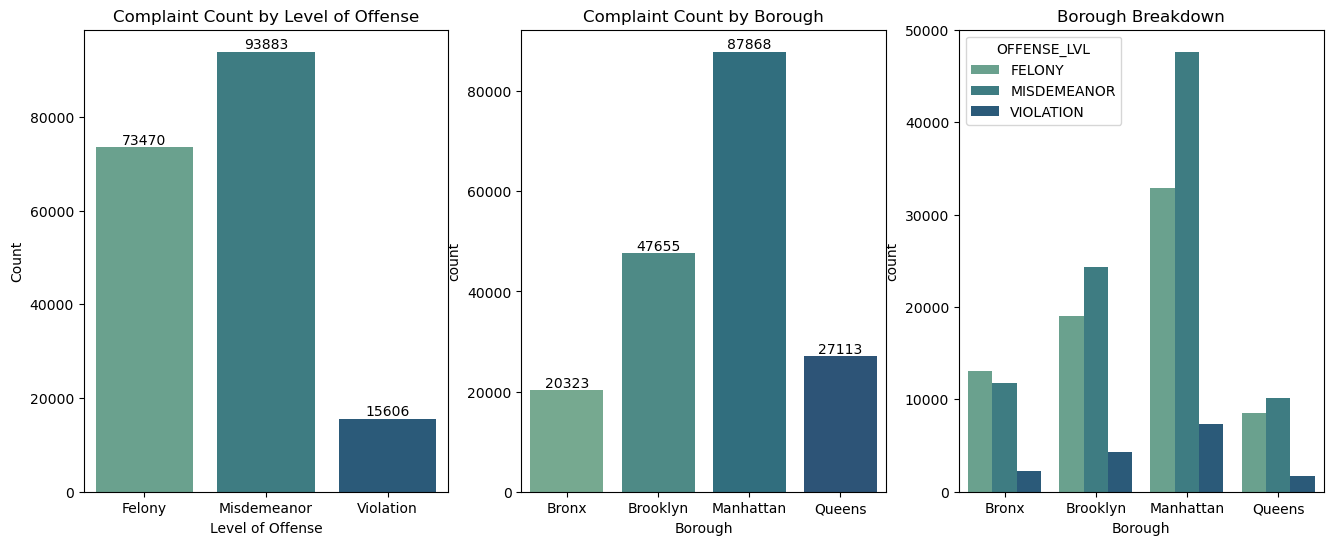

In [13]:
plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
crime = sns.countplot(x='OFFENSE_LVL', data=data, palette = 'crest')
crime.bar_label(crime.containers[0])
labels = ['Felony','Misdemeanor','Violation']
plt.xticks(range(3), labels)
plt.ylabel('Count')
plt.xlabel('Level of Offense')
plt.title('Complaint Count by Level of Offense')
#plt.savefig('CountbyLO.png', bbox_inches='tight')

plt.subplot(1,3,2)
location = sns.countplot(x='BOROUGH', data=data, palette = 'crest')
location.bar_label(location.containers[0])
labels = ['Bronx','Brooklyn','Manhattan', 'Queens']
plt.xticks(range(4), labels)
#plt.ylabel('Count')
plt.xlabel('Borough')
plt.title('Complaint Count by Borough')
#plt.savefig('countbyborough.png', bbox_inches='tight')

plt.subplot(1,3,3)
crime = sns.countplot(x=b, hue='OFFENSE_LVL', data=data, palette = 'crest')
labels = ['Bronx','Brooklyn','Manhattan', 'Queens']
plt.xticks(range(4), labels)
#plt.ylabel('Count')
plt.xlabel('Borough')
plt.title('Borough Breakdown')
#plt.savefig('BoroughBreakdown.png', bbox_inches='tight')

plt.show()

According to city population, https://www.citypopulation.de/en/usa/newyorkcity/, Brooklyn is the most populated borough with 2.56 million residents as of July 2022, followed by Queens with 2.25m, Manhattan with 1.6m, the Bronx with 1.35m, and Staten Island with 491,000. Brooklyn also has the largest number of stations, followed by Manhattan, Queens, and the Bronx. Staten Island does not have any subway stations and so is not part of this study. A breakdown by Offense level and Borough shows that where complaints of crime are being made does not line up with population and station statistics.

#### Plot Top 10 Types of Crimes and Top 10 Stations for Highest Complaint Rate
 - 9 out of 10 stations are in Manhattan

In [14]:
top_10_crimes = data['OFNS_DESC'].value_counts().head(10)
top_10_stations = data['STATION_NAME'].value_counts().head(10)

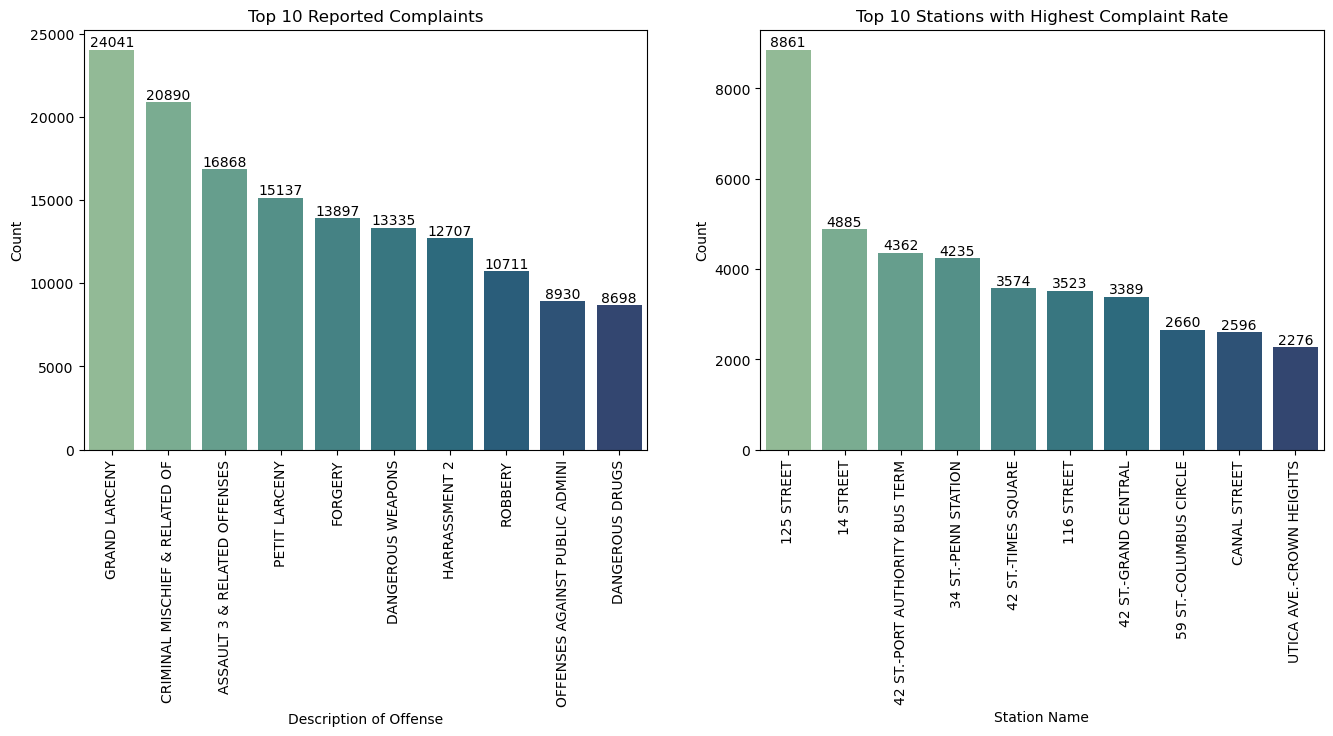

In [15]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
crime = sns.barplot(x=top_10_crimes.index, y=top_10_crimes.values, palette = 'crest')
crime.bar_label(crime.containers[0])
plt.xlabel('Description of Offense')
plt.ylabel('Count')
plt.title('Top 10 Reported Complaints')
plt.xticks(rotation=90)
#plt.savefig('Top10Complaints.png', bbox_inches='tight')

plt.subplot(2,2,2)
location = sns.barplot(x=top_10_stations.index, y=top_10_stations.values, palette = 'crest')
location.bar_label(location.containers[0])
plt.xlabel('Station Name')
plt.ylabel('Count')
plt.title('Top 10 Stations with Highest Complaint Rate')
plt.xticks(rotation=90)
#plt.savefig('Top10Stations.png', bbox_inches='tight')
plt.show()

#### Convert categorical data into indicator variables with values True = 1, False = 0

In [16]:
df = pd.get_dummies(data, columns=['OFFENSE_LVL', 'BOROUGH'], prefix_sep='', prefix='')
print(data)

        COMPLAINT_ID COMPLAINT_DATE COMPLAINT_TIME CMPLNT_TO_DT CMPLNT_TO_TM  \
0           23320709     2006-01-01       12:01 AM     7/3/2006     23:59:00   
1           13736560     2006-01-01        7:00 PM    5/10/2006     14:00:00   
2            9935387     2006-01-01        1:00 AM     1/1/2006      3:00:00   
3            9932532     2006-01-01        5:20 AM          NaN       (null)   
4           10155213     2006-01-01        7:30 AM          NaN       (null)   
...              ...            ...            ...          ...          ...   
182954     138673042            NaN        9:13 PM    9/11/2014     21:15:00   
182955      75850750            NaN        5:30 PM    12/2/2010     17:35:00   
182956      75712018            NaN        8:30 AM   11/24/2010      8:33:00   
182957      71969182            NaN       12:25 AM          NaN       (null)   
182958      24608492            NaN        2:30 PM    9/28/2006     15:00:00   

        ADDR_PCT_CD REPORT_DATE  KY_CD 

In [17]:
df = df.replace({True: 1, False: 0})
df.head(5)

COMPLAINT_ID COMPLAINT_DATE COMPLAINT_TIME CMPLNT_TO_DT CMPLNT_TO_TM  \
0      23320709     2006-01-01       12:01 AM     7/3/2006     23:59:00   
1      13736560     2006-01-01        7:00 PM    5/10/2006     14:00:00   
2       9935387     2006-01-01        1:00 AM     1/1/2006      3:00:00   
3       9932532     2006-01-01        5:20 AM          NaN       (null)   
4      10155213     2006-01-01        7:30 AM          NaN       (null)   

   ADDR_PCT_CD REPORT_DATE  KY_CD                       OFNS_DESC  PD_CD  \
0        104.0  2006-07-06    121  CRIMINAL MISCHIEF & RELATED OF    269   
1         62.0  2006-05-10    351  CRIMINAL MISCHIEF & RELATED OF    258   
2         61.0  2006-01-01    341                   PETIT LARCENY    339   
3        115.0  2006-01-01    109                   GRAND LARCENY    419   
4          9.0  2006-01-01    109                   GRAND LARCENY    415   

                          PD_DESC CRIME_ATTEMPT LOC_OF_OCCUR_DESC  \
0  MISCHIEF,CRIMINAL,    UNCL 2ND     COMPLETED            (null)   
1  CRIMINAL MISCHIEF 4TH, GRAFFIT     COMPLETED            (null)   
2  LARCENY,PETIT FROM OPEN AREAS,     COMPLETED            (null)   
3  LARCENY,GRAND FROM PERSON,UNCL     COMPLETED            (null)   
4  LARCENY,GRAND FROM PERSON,PICK     COMPLETED            (null)   

          PREM_TYP_DESC           JURIS_DESC  JURIS_CODE PARKS_NM HADEVELOPT  \
0  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   (null)     (null)   
1  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   (null)     (null)   
2  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   (null)     (null)   
3  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   (null)     (null)   
4  TRANSIT - NYC SUBWAY  N.Y. TRANSIT POLICE           1   (null)     (null)   

  HOUSING_PSA    X_COORD   Y_COORD SUSP_AGE SUSP_RACE SUSP_SEX  \
0      (null)  1010686.0  192838.0  UNKNOWN   UNKNOWN  UNKNOWN   
1      (null)   988511.0  164316.0  UNKNOWN   UNKNOWN  UNKNOWN   
2      (null)   996967.0  153279.0    18-24     WHITE        M   
3      (null)  1014333.0  211391.0  UNKNOWN     BLACK        M   
4      (null)   986624.0  205185.0  UNKNOWN   UNKNOWN  UNKNOWN   

   TRANSIT_DISTRICT   Latitude  Longitude                      Lat_Lon  \
0                33  40.695933 -73.904666  (40.69593301, -73.90466563)   
1                34  40.617685 -73.984652  (40.61768484, -73.98465185)   
2                34  40.587382 -73.954214  (40.58738242, -73.95421409)   
3                20  40.746845 -73.891431  (40.74684483, -73.89143078)   
4                 4  40.729862 -73.991434  (40.72986175, -73.99143444)   

                PATROL_BORO     STATION_NAME  VIC_AGE VIC_RACE  VIC_SEX  \
0  PATROL BORO QUEENS NORTH    HALSEY STREET  UNKNOWN  UNKNOWN  UNKNOWN   
1   PATROL BORO BKLYN SOUTH        59 STREET  UNKNOWN  UNKNOWN  UNKNOWN   
2   PATROL BORO BKLYN SOUTH   SHEEPSHEAD BAY    18-24    WHITE        F   
3  PATROL BORO QUEENS NORTH  74 ST.-BROADWAY    18-24    WHITE        M   
4     PATROL BORO MAN SOUTH      ASTOR PLACE    18-24    BLACK        M   

   Zip Code  Comm_Dist  Boro_Boundary  City_Council_Dist  Police_Precinct  \
0   15310.0       42.0            3.0               37.0             53.0   
1   16867.0        1.0            2.0               45.0             37.0   
2   13826.0       32.0            2.0               15.0             36.0   
3   14784.0       65.0            3.0                5.0             73.0   
4   11724.0       57.0            4.0               50.0              5.0   

             DATETIME  FELONY  MISDEMEANOR  VIOLATION  BRONX  BROOKLYN  \
0 2006-01-01 00:01:00       1            0          0      0         0   
1 2006-01-01 19:00:00       0            1          0      0         1   
2 2006-01-01 01:00:00       0            1          0      0         1   
3 2006-01-01 05:20:00       1            0          0      0         0   
4 2006-01-01 07:30:00       1            0          0      0         0   

In [18]:
df = df[['COMPLAINT_DATE', 'FELONY', 'MISDEMEANOR', 'VIOLATION', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATION_NAME', 'City_Council_Dist', 'Police_Precinct']]
df.head()

COMPLAINT_DATE  FELONY  MISDEMEANOR  VIOLATION  BRONX  BROOKLYN  MANHATTAN  \
0     2006-01-01       1            0          0      0         0          0   
1     2006-01-01       0            1          0      0         1          0   
2     2006-01-01       0            1          0      0         1          0   
3     2006-01-01       1            0          0      0         0          0   
4     2006-01-01       1            0          0      0         0          1   

   QUEENS     STATION_NAME  City_Council_Dist  Police_Precinct  
0       1    HALSEY STREET               37.0             53.0  
1       0        59 STREET               45.0             37.0  
2       0   SHEEPSHEAD BAY               15.0             36.0  
3       1  74 ST.-BROADWAY                5.0             73.0  
4       0      ASTOR PLACE               50.0              5.0

#### Remove Nulls

In [19]:
df.isnull().sum()

COMPLAINT_DATE       5
FELONY               0
MISDEMEANOR          0
VIOLATION            0
BRONX                0
BROOKLYN             0
MANHATTAN            0
QUEENS               0
STATION_NAME         0
City_Council_Dist    2
Police_Precinct      2
dtype: int64

In [20]:
df = df.dropna()

In [21]:
df['DATETIME'] = pd.to_datetime(df['COMPLAINT_DATE'])

In [22]:
df = df.drop('COMPLAINT_DATE', axis = 1)

#### Create columns specifically for Year, Month and Day

In [23]:
df['YEAR'] = df['DATETIME'].dt.year
df['MONTH'] = df['DATETIME'].dt.month
df['DAY'] = df['DATETIME'].dt.day

In [24]:
df.head(5)

FELONY  MISDEMEANOR  VIOLATION  BRONX  BROOKLYN  MANHATTAN  QUEENS  \
0       1            0          0      0         0          0       1   
1       0            1          0      0         1          0       0   
2       0            1          0      0         1          0       0   
3       1            0          0      0         0          0       1   
4       1            0          0      0         0          1       0   

      STATION_NAME  City_Council_Dist  Police_Precinct   DATETIME  YEAR  \
0    HALSEY STREET               37.0             53.0 2006-01-01  2006   
1        59 STREET               45.0             37.0 2006-01-01  2006   
2   SHEEPSHEAD BAY               15.0             36.0 2006-01-01  2006   
3  74 ST.-BROADWAY                5.0             73.0 2006-01-01  2006   
4      ASTOR PLACE               50.0              5.0 2006-01-01  2006   

   MONTH  DAY  
0      1    1  
1      1    1  
2      1    1  
3      1    1  
4      1    1

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182952 entries, 0 to 182953
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FELONY             182952 non-null  int64         
 1   MISDEMEANOR        182952 non-null  int64         
 2   VIOLATION          182952 non-null  int64         
 3   BRONX              182952 non-null  int64         
 4   BROOKLYN           182952 non-null  int64         
 5   MANHATTAN          182952 non-null  int64         
 6   QUEENS             182952 non-null  int64         
 7   STATION_NAME       182952 non-null  object        
 8   City_Council_Dist  182952 non-null  float64       
 9   Police_Precinct    182952 non-null  float64       
 10  DATETIME           182952 non-null  datetime64[ns]
 11  YEAR               182952 non-null  int32         
 12  MONTH              182952 non-null  int32         
 13  DAY                182952 non-null  int32        

In [26]:
df = df[['DATETIME', 'YEAR', 'MONTH', 'DAY', 'FELONY', 'MISDEMEANOR', 'VIOLATION', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATION_NAME', 'City_Council_Dist', 'Police_Precinct']]
df.head(5)

DATETIME  YEAR  MONTH  DAY  FELONY  MISDEMEANOR  VIOLATION  BRONX  \
0 2006-01-01  2006      1    1       1            0          0      0   
1 2006-01-01  2006      1    1       0            1          0      0   
2 2006-01-01  2006      1    1       0            1          0      0   
3 2006-01-01  2006      1    1       1            0          0      0   
4 2006-01-01  2006      1    1       1            0          0      0   

   BROOKLYN  MANHATTAN  QUEENS     STATION_NAME  City_Council_Dist  \
0         0          0       1    HALSEY STREET               37.0   
1         1          0       0        59 STREET               45.0   
2         1          0       0   SHEEPSHEAD BAY               15.0   
3         0          0       1  74 ST.-BROADWAY                5.0   
4         0          1       0      ASTOR PLACE               50.0   

   Police_Precinct  
0             53.0  
1             37.0  
2             36.0  
3             73.0  
4              5.0

#### Plot Complaints by Borough

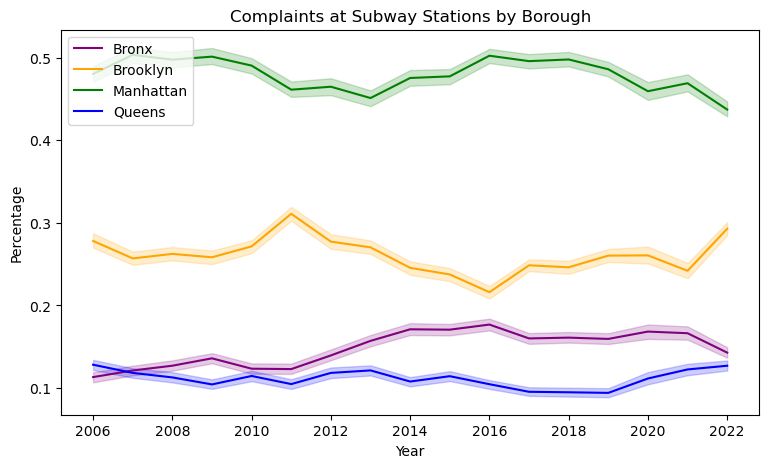

In [27]:
plt.figure(figsize=(9,5))
sns.lineplot(data=df, x='YEAR', y='BRONX', color = 'purple', label = 'Bronx')
sns.lineplot(data=df, x='YEAR', y='BROOKLYN', color = 'orange', label = 'Brooklyn')
sns.lineplot(data=df, x='YEAR', y='MANHATTAN', color = 'green', label = 'Manhattan')
sns.lineplot(data=df, x='YEAR', y='QUEENS', color = 'blue', label = 'Queens')
plt.legend(loc= 'upper left')

plt.title("Complaints at Subway Stations by Borough")
plt.xlabel("Year")
plt.ylabel("Percentage")
#plt.savefig('BoroughCCOverTime.png', bbox_inches='tight')
plt.show()

#### Plot felonies, misdemeanors, and violations over time

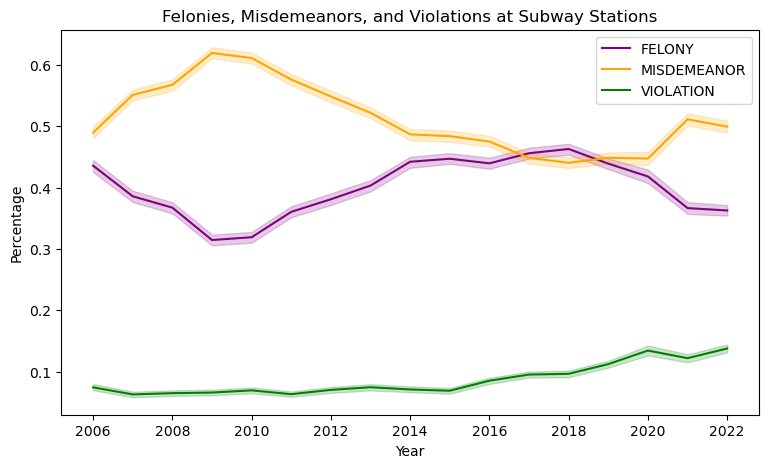

In [28]:
plt.figure(figsize=(9,5))
sns.lineplot(data=df, x='YEAR', y='FELONY', color = 'purple', label = 'FELONY')
sns.lineplot(data=df, x='YEAR', y='MISDEMEANOR', color = 'orange', label = 'MISDEMEANOR')
sns.lineplot(data=df, x='YEAR', y='VIOLATION', color = 'green', label = 'VIOLATION')
plt.legend()
plt.title("Felonies, Misdemeanors, and Violations at Subway Stations")
plt.xlabel("Year")
plt.ylabel("Percentage")
#plt.savefig('OffenseLevelYearly.png', bbox_inches='tight')
plt.show()

#### Drop columns and reorder the rest

In [29]:
df1 = df[['DATETIME','YEAR', 'MONTH', 'DAY', 'FELONY', 'MISDEMEANOR', 'VIOLATION', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATION_NAME']]
df1.head(5)

DATETIME  YEAR  MONTH  DAY  FELONY  MISDEMEANOR  VIOLATION  BRONX  \
0 2006-01-01  2006      1    1       1            0          0      0   
1 2006-01-01  2006      1    1       0            1          0      0   
2 2006-01-01  2006      1    1       0            1          0      0   
3 2006-01-01  2006      1    1       1            0          0      0   
4 2006-01-01  2006      1    1       1            0          0      0   

   BROOKLYN  MANHATTAN  QUEENS     STATION_NAME  
0         0          0       1    HALSEY STREET  
1         1          0       0        59 STREET  
2         1          0       0   SHEEPSHEAD BAY  
3         0          0       1  74 ST.-BROADWAY  
4         0          1       0      ASTOR PLACE

---

# Modeling

#### Predict 
- whether a crime was committed at a Subway station in Manhattan.
- whether a crime is a Felony

#### Models used
- Logistic Regression
- Bernoulli Naive-Bayes
- Gaussian Naive-Bayes

## Borough - Manhattan

In [30]:
feature_cols = ['YEAR', 'MONTH', 'DAY', 'FELONY', 'MISDEMEANOR', 'VIOLATION']
X = df1[feature_cols]
y = df1.MANHATTAN      

In [31]:
# test size will be 20% 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

In [32]:
# scale the input data

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 1 - Logistic Regression

In [33]:
LR = LogisticRegression()

#--fit the model with data
LR.fit(X_train, y_train)

LogisticRegression()

In [34]:
y_pred = LR.predict(X_test)

In [35]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(LR.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LR.score(X_test, y_test)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred)))

Accuracy of logistic regression classifier on train set: 0.53
Accuracy of logistic regression classifier on test set: 0.53
Precision of logistic regression classifier on test set: 0.50


In [36]:
# Actual vs Predicted values 

result = pd.DataFrame({'MANHATTAN' : y_test, 'Predicted' : y_pred})
result

MANHATTAN  Predicted
69230           1          1
145767          0          1
33480           0          1
7428            0          0
135696          0          0
...           ...        ...
113826          1          0
94638           1          0
40539           1          1
92293           1          1
62379           0          1

[36591 rows x 2 columns]

In [37]:
importance = LR.coef_[0]

for i,j in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,j))

for k in enumerate(X.columns):
    print(k)
    

# print('')
# print(f'Intercept: {LR.intercept_}')

Feature: 0, Score: -0.02501
Feature: 1, Score: -0.00135
Feature: 2, Score: 0.00323
Feature: 3, Score: -0.05926
Feature: 4, Score: 0.06109
Feature: 5, Score: -0.00527
(0, 'YEAR')
(1, 'MONTH')
(2, 'DAY')
(3, 'FELONY')
(4, 'MISDEMEANOR')
(5, 'VIOLATION')


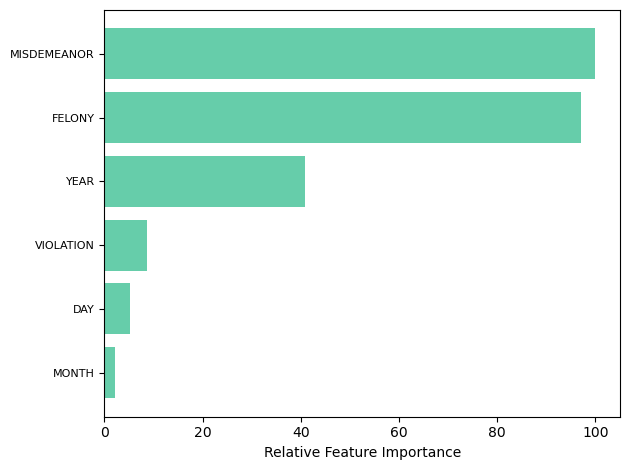

In [38]:
feature_importance = abs(LR.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color = 'mediumaquamarine')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()   
#plt.savefig('ManhattanFeatureImportance.png', bbox_inches='tight')
plt.show()

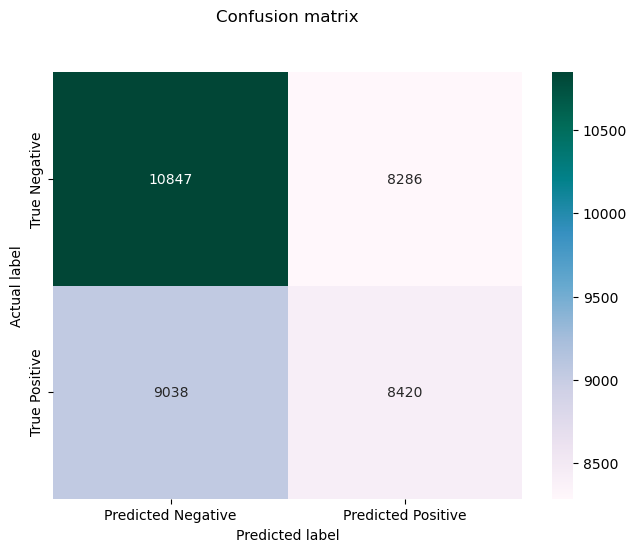

In [39]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuBuGn" ,fmt='g', 
            xticklabels = ['Predicted Negative', 'Predicted Positive'], 
            yticklabels = ['True Negative', 'True Positive'])
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
#plt.savefig('ManhLRCM1.png', bbox_inches='tight')

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56     19133
           1       0.50      0.48      0.49     17458

    accuracy                           0.53     36591
   macro avg       0.52      0.52      0.52     36591
weighted avg       0.53      0.53      0.53     36591



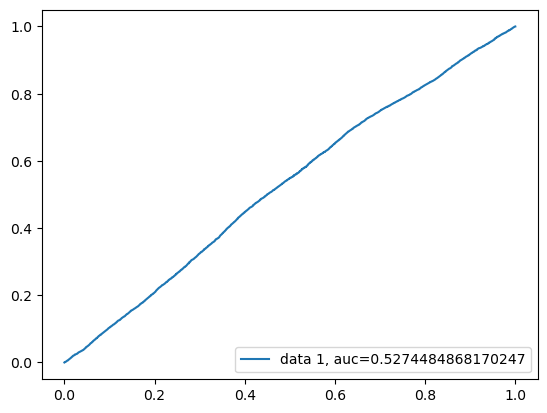

In [41]:
y_pred_proba = LR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
#plt.savefig('ManhLRAUC1.png', bbox_inches='tight')
plt.show()

## 2 - Bernoulli Naive-Bayes

In [42]:
bnb = BernoulliNB(binarize=0.0)
model = bnb.fit(X_train, y_train)
y_pred1 = bnb.predict(X_test)

In [43]:
acc = accuracy_score(y_pred1, y_test)

print(f'Accuracy score: {acc}')

Accuracy score: 0.5237353447569074


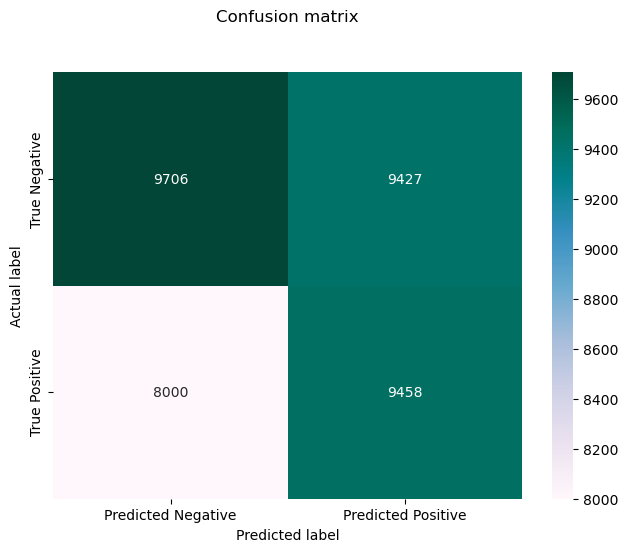

In [44]:
cm1 = confusion_matrix(y_test, y_pred1)

sns.heatmap(cm1, cmap="PuBuGn" ,fmt='g', annot = True, 
            xticklabels = ['Predicted Negative', 'Predicted Positive'], 
            yticklabels = ['True Negative', 'True Positive'])
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('ManhBNBCM2.png', bbox_inches='tight')
plt.show()

In [45]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53     19133
           1       0.50      0.54      0.52     17458

    accuracy                           0.52     36591
   macro avg       0.52      0.52      0.52     36591
weighted avg       0.53      0.52      0.52     36591



## 3 - Gaussian Naive-Bayes

In [46]:
gnb = GaussianNB()

# train the model
gnb.fit(X_train, y_train)

# test the model
y_pred2 = gnb.predict(X_test)

In [47]:
acc1 = accuracy_score(y_test,y_pred2)

print(f'Accuracy score: {acc1}')

Accuracy score: 0.5237353447569074


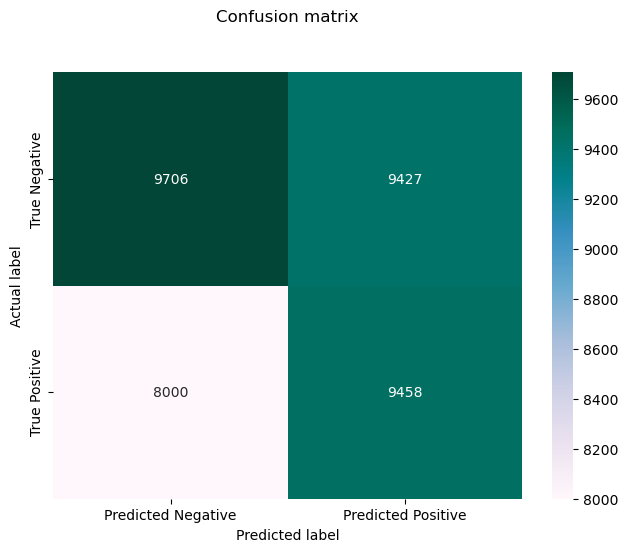

In [48]:
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, cmap="PuBuGn" ,fmt='g', annot=True,
            xticklabels = ['Predicted Negative', 'Predicted Positive'], 
            yticklabels = ['True Negative', 'True Positive'])
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('ManhGNBCM3.png', bbox_inches='tight')
plt.show()

In [49]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53     19133
           1       0.50      0.54      0.52     17458

    accuracy                           0.52     36591
   macro avg       0.52      0.52      0.52     36591
weighted avg       0.53      0.52      0.52     36591



## 4 - Logistic Regression

## Offense Level - Felony

In [50]:
feature_cols = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'YEAR']
X = df1[feature_cols]
y = df1.FELONY

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

In [52]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [53]:
LR = LogisticRegression()

#--fit the model with data
LR.fit(X_train, y_train)

LogisticRegression()

In [54]:
y_pred = LR.predict(X_test)

In [55]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(LR.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LR.score(X_test, y_test)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred)))

Accuracy of logistic regression classifier on train set: 0.60
Accuracy of logistic regression classifier on test set: 0.60
Precision of logistic regression classifier on test set: 0.43


In [56]:
importance = LR.coef_[0]

for i,j in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,j))

for k in enumerate(X.columns):
    print(k)
    

print('')
print(f'Intercept: {LR.intercept_}')

Feature: 0, Score: 0.09920
Feature: 1, Score: -0.01121
Feature: 2, Score: -0.07151
Feature: 3, Score: 0.01737
Feature: 4, Score: 0.06480
(0, 'BRONX')
(1, 'BROOKLYN')
(2, 'MANHATTAN')
(3, 'QUEENS')
(4, 'YEAR')

Intercept: [-0.39830507]


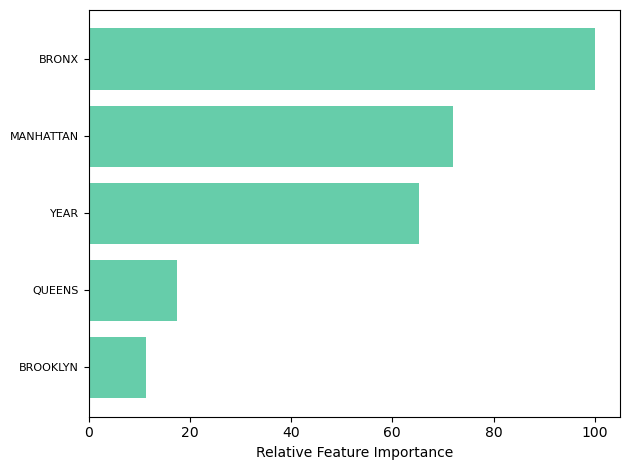

In [57]:
feature_importance = abs(LR.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color = 'mediumaquamarine')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()   
#plt.savefig('FelonyFI.png', bbox_inches='tight')
plt.show()

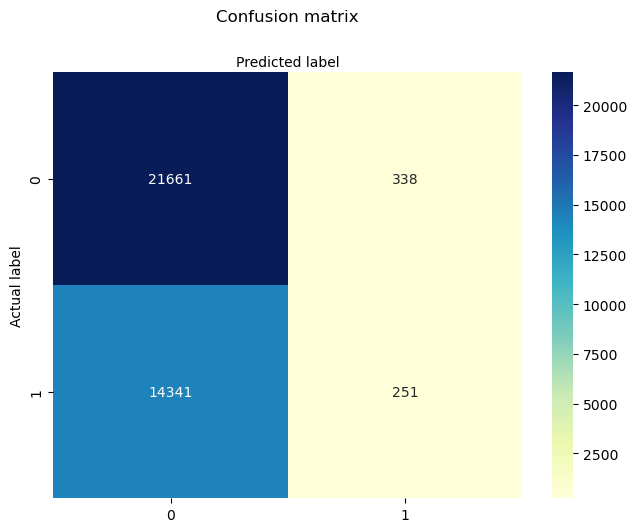

In [58]:
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('FelonyLRCM4.png', bbox_inches='tight')
plt.show()

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.98      0.75     21999
           1       0.43      0.02      0.03     14592

    accuracy                           0.60     36591
   macro avg       0.51      0.50      0.39     36591
weighted avg       0.53      0.60      0.46     36591



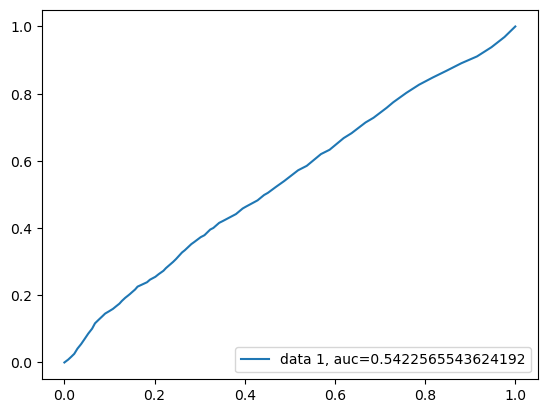

In [60]:
y_pred_proba = LR.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

----

## Time Series Analysis
- Review the effects of COVID-19 on the number of complaints made to the NYPD

In [61]:
# for work including COVID-19 dates, use 'data'

data['DATETIME'].min(), data['DATETIME'].max()

(Timestamp('2006-01-01 00:01:00'), Timestamp('2022-12-31 22:00:00'))

In [62]:
# for work excluding COVID-19 dates, use 'data1' 

data1['DATETIME'].min(), data1['DATETIME'].max()

(Timestamp('2006-01-01 00:01:00'), Timestamp('2019-12-31 23:45:00'))

In [63]:
df2 = data[['DATETIME']]
df2.isnull().sum()

DATETIME    5
dtype: int64

In [64]:
df2.isnull().sum()

DATETIME    5
dtype: int64

In [65]:
df2 = df2.dropna()

In [66]:
df3 = data1[['DATETIME']]
df3.isnull().sum()

DATETIME    0
dtype: int64

In [67]:
df2.index = pd.to_datetime(df2.DATETIME, format = '%Y-%m-%d')
del df2['DATETIME']

In [68]:
df3.index = pd.to_datetime(df3.DATETIME, format = '%Y-%m-%d')
del df3['DATETIME']

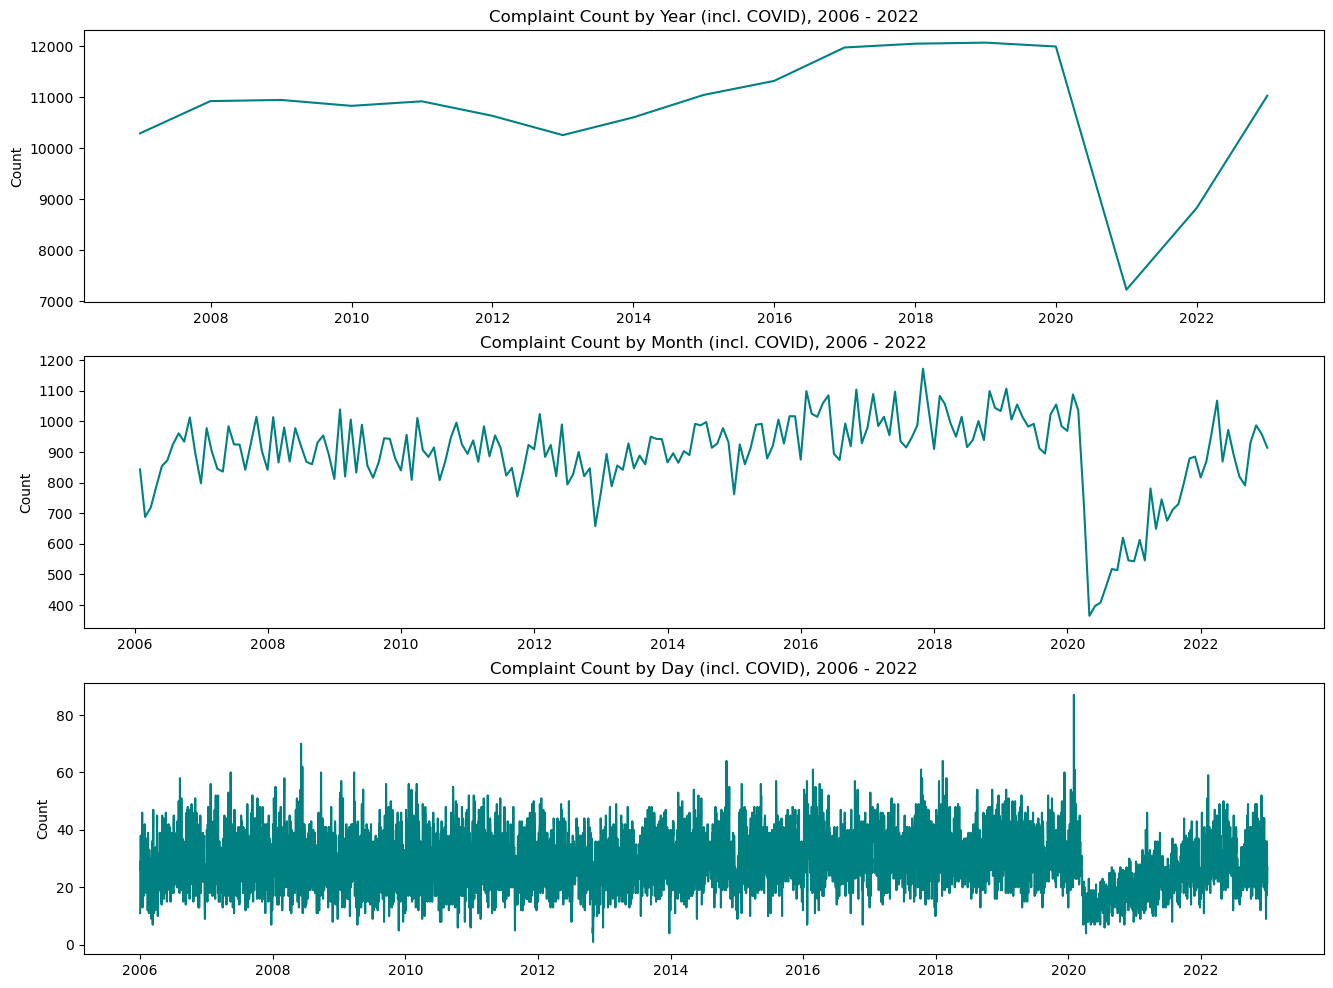

In [69]:
plt.figure(figsize=(16,12))

plt.subplot(3,1,1)
plt.plot(df2.resample('Y').size(), color = 'teal')
plt.title("Complaint Count by Year (incl. COVID), 2006 - 2022")
#plt.xlabel("Year")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyYearCovid.png', bbox_inches='tight')

plt.subplot(3,1,2)
plt.plot(df2.resample('M').size(), color = 'teal')
plt.title("Complaint Count by Month (incl. COVID), 2006 - 2022")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyMonthCovid.png', bbox_inches='tight')

plt.subplot(3,1,3)
plt.plot(df2.resample('D').size(), color = 'teal')
plt.title("Complaint Count by Day (incl. COVID), 2006 - 2022")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyDayCovid.png', bbox_inches='tight')
plt.show()

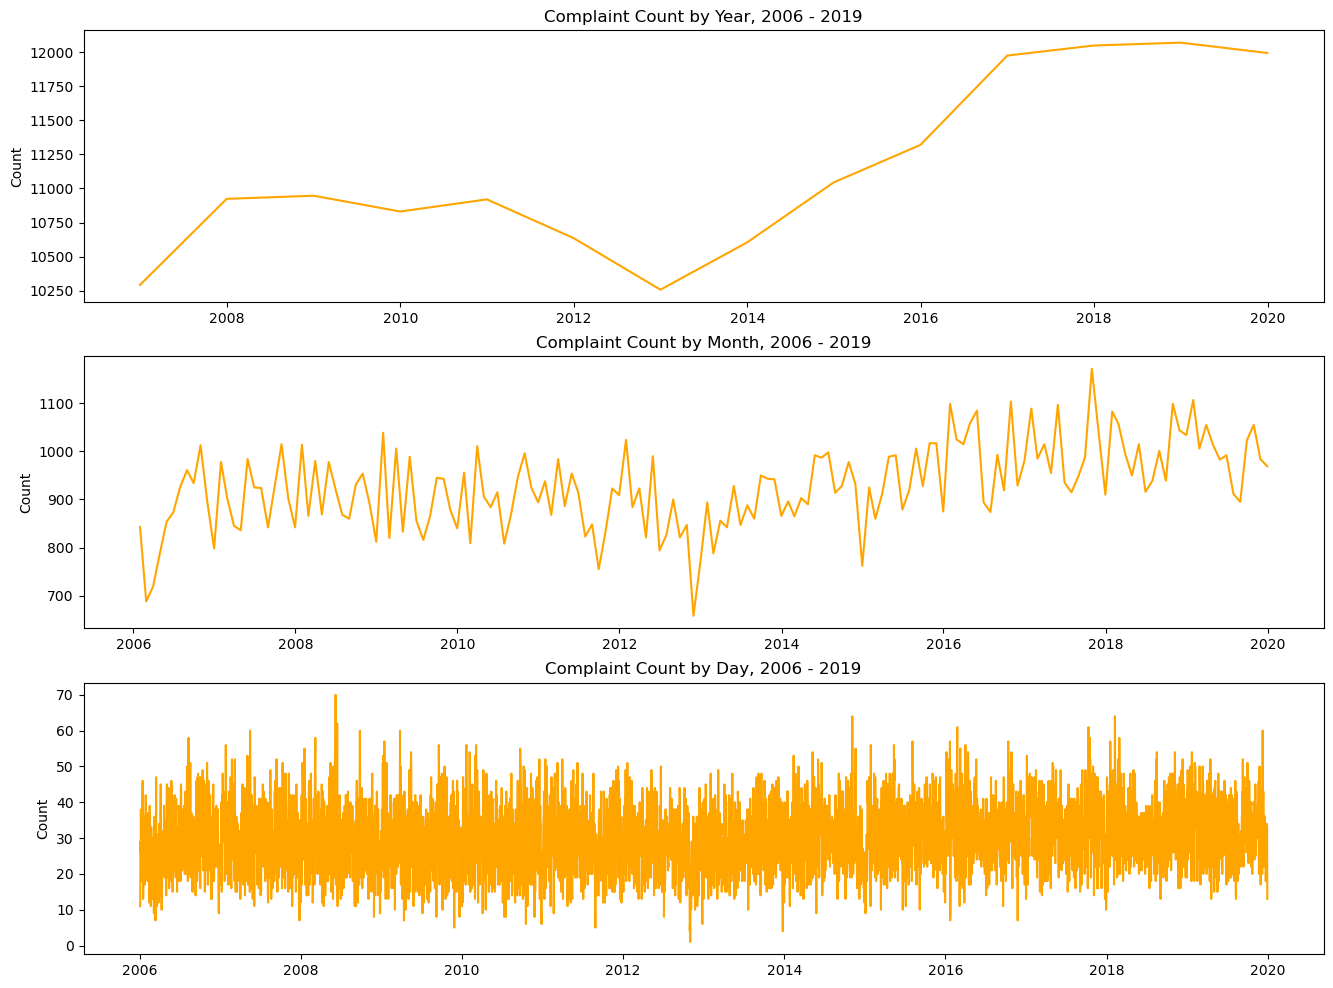

In [70]:
plt.figure(figsize=(16,12))

plt.subplot(3,1,1)
plt.plot(df3.resample('Y').size(), color = 'orange')
plt.title("Complaint Count by Year, 2006 - 2019")
#plt.xlabel("Year")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyYear.png', bbox_inches='tight')

plt.subplot(3,1,2)
plt.plot(df3.resample('M').size(), color = 'orange')
plt.title("Complaint Count by Month, 2006 - 2019")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyMonth.png', bbox_inches='tight')

plt.subplot(3,1,3)
plt.plot(df3.resample('D').size(), color = 'orange')
plt.title("Complaint Count by Day, 2006 - 2019")
plt.ylabel("Count")
#plt.savefig('ComplaintCountbyDay.png', bbox_inches='tight')
plt.show()

#### Create lists of complaint counts by Month, Week and Day
- df2 includes COVID-19 dates
- df3 excludes COVID-19 dates

In [71]:
df2_monthly = pd.DataFrame(df2.resample('M').size().reset_index())
df2_monthly.columns = ['Month', 'MCC']
df2_monthly.index = pd.to_datetime(df2_monthly.Month, format = '%Y-%m-%d')
del df2_monthly['Month']

df2_weekly = pd.DataFrame(df2.resample('W').size().reset_index())
df2_weekly.columns = ['Week', 'WCC']
df2_weekly.index = pd.to_datetime(df2_weekly.Week, format = '%Y-%m-%d')
del df2_weekly['Week']

df2_daily = pd.DataFrame(df2.resample('D').size().reset_index())
df2_daily.columns = ['Day', 'DCC']
df2_daily.index = pd.to_datetime(df2_daily.Day, format = '%Y-%m-%d')
del df2_daily['Day']

In [72]:
df3_monthly = pd.DataFrame(df3.resample('M').size().reset_index())
df3_monthly.columns = ['Month', 'MCC']
df3_monthly.index = pd.to_datetime(df3_monthly.Month, format = '%Y-%m-%d')
del df3_monthly['Month']

df3_weekly = pd.DataFrame(df3.resample('W').size().reset_index())
df3_weekly.columns = ['Week', 'WCC']
df3_weekly.index = pd.to_datetime(df3_weekly.Week, format = '%Y-%m-%d')
del df3_weekly['Week']

df3_daily = pd.DataFrame(df3.resample('D').size().reset_index())
df3_daily.columns = ['Day', 'DCC']
df3_daily.index = pd.to_datetime(df3_daily.Day, format = '%Y-%m-%d')
del df3_daily['Day']

## ARIMA Model
- Autoregressive Integrated Moving Average
- Time Series Analysis and Forecasting utilizing ARIMA, and possibly, SARIMA models.
- After looking at Monthly, Weekly, and Daily totals chose to work with Monthly data. 

## Model 1
- Built with all data, INCLUDING COVID-19

In [73]:
y = df2_monthly['MCC']

In [74]:
y['2018'].head(5)

Month
2018-01-31    1083
2018-02-28    1057
2018-03-31     994
2018-04-30     950
2018-05-31    1015
Name: MCC, dtype: int64

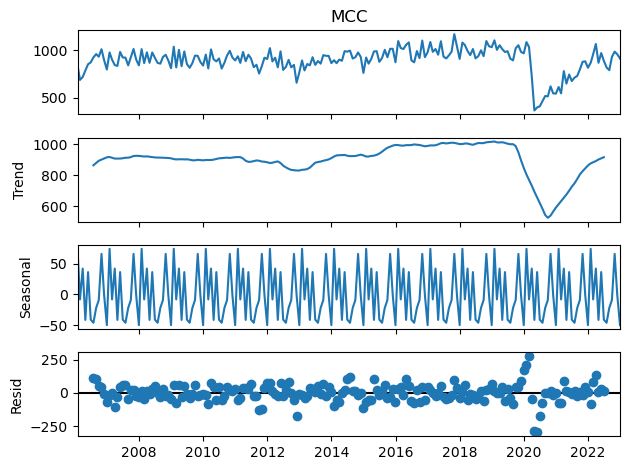

In [75]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
#plt.savefig('Decomposition1.png', bbox_inches='tight')
plt.show()

In [76]:
def ad_test(data):
    dftest=adfuller(data,autolag='AIC')
    print('1. ADF:',dftest[0])
    print('2. P-Value:',dftest[1])
    print('3. Number of lags:',dftest[2])
    print('4. Number of observations',dftest[3])
    print('5. Critical Values:')
    for key,val in dftest[4].items():
        print('\t',key,':',val)
        
ad_test(df2_monthly['MCC'])

1. ADF: -3.0269406737421543
2. P-Value: 0.032453932086204854
3. Number of lags: 12
4. Number of observations 191
5. Critical Values:
	 1% : -3.465058702600837
	 5% : -2.8767942675230356
	 10% : -2.5749014492475535


A p-value < 0.05 indicates there is seasonality.

In [77]:
# a second test to determine seasonality

from scipy.stats import kruskal

def seasonality_test(series):
        seasonal = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal
    
seasonality_test(y)

True

In [78]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [79]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3342.922671559759
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2940.0332592102873
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2486.735092766177
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2286.9952750216703
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2500.5881048742967
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2437.519705021242
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2334.601276225848
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2281.9188015440286
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3096.531293583209
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2733.345037576354
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2357.375582353885
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2166.7482582730854
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2383.5592890030284
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2310.497934699425
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2223.3103184536994
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2162.9698749634817
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2434.781653193177
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2262.767525668849
AR

In [80]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 MCC   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1124.312
Date:                             Fri, 03 May 2024   AIC                           2256.625
Time:                                     15:45:45   BIC                           2269.634
Sample:                                 01-31-2006   HQIC                          2261.894
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4204      0.270      1.555      0.120      -0.110       0.950
ma.L1         -0.6360      

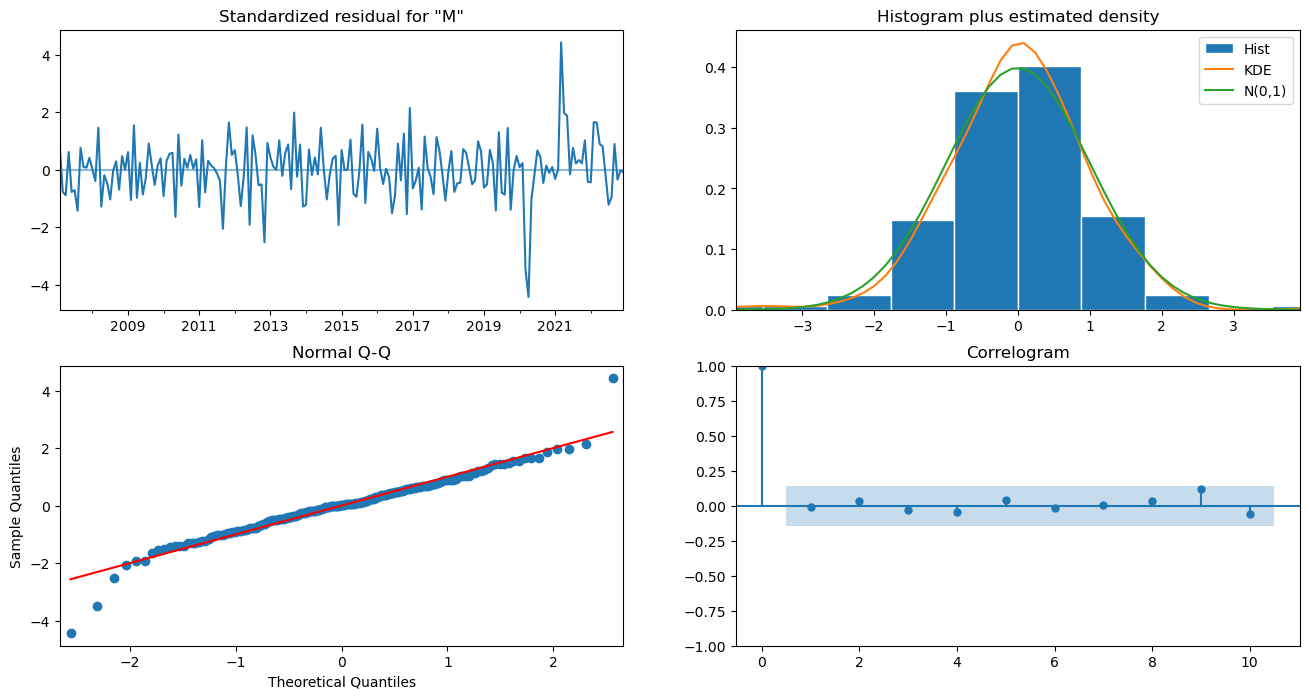

In [81]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

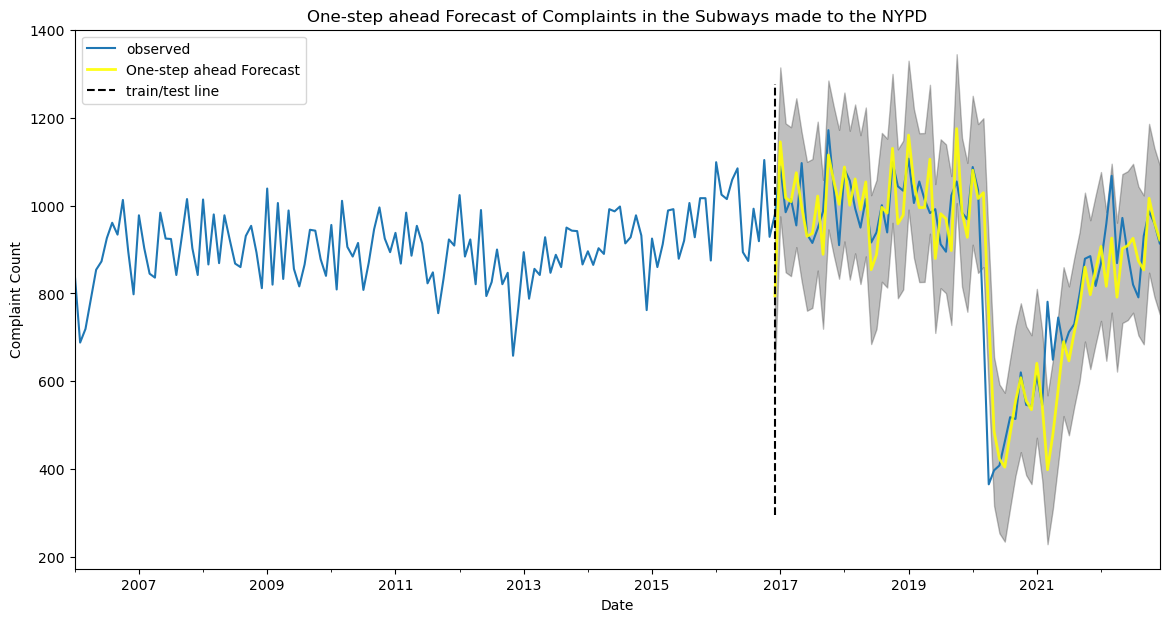

In [82]:
pred = results.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2006-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('One-step ahead Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDOSAF.png', bbox_inches='tight')
plt.show()

In [83]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-12-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 3)))

The Mean Squared Error of our forecasts is 10261.467
The Root Mean Squared Error of our forecasts is 101.299


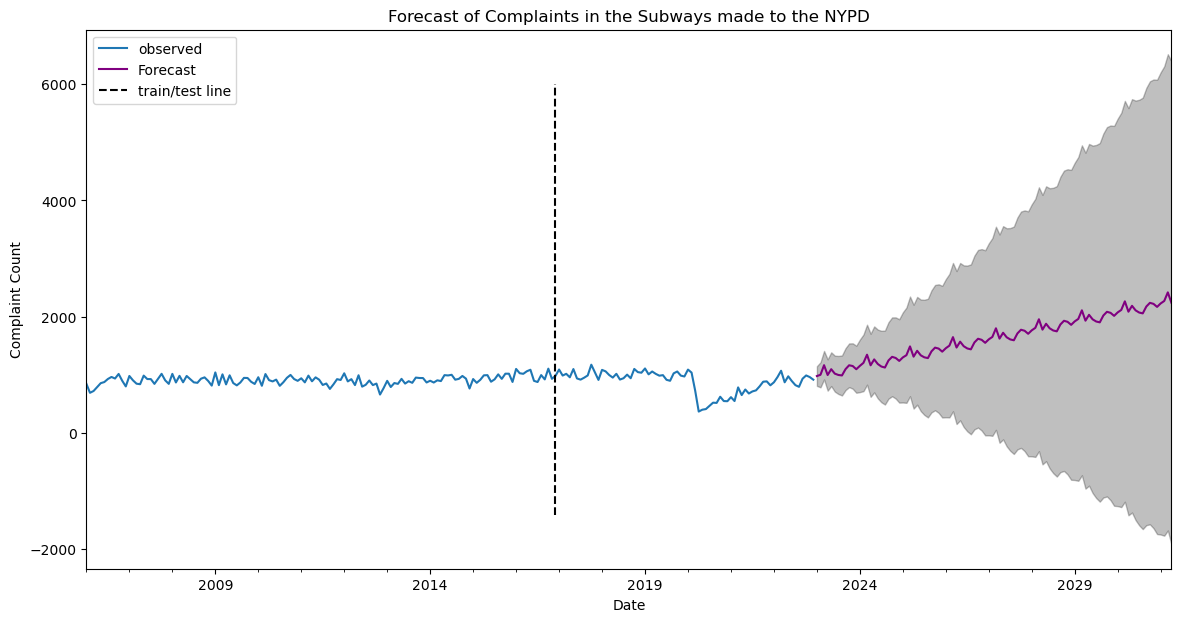

In [84]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDForecast.png', bbox_inches='tight')
plt.show()

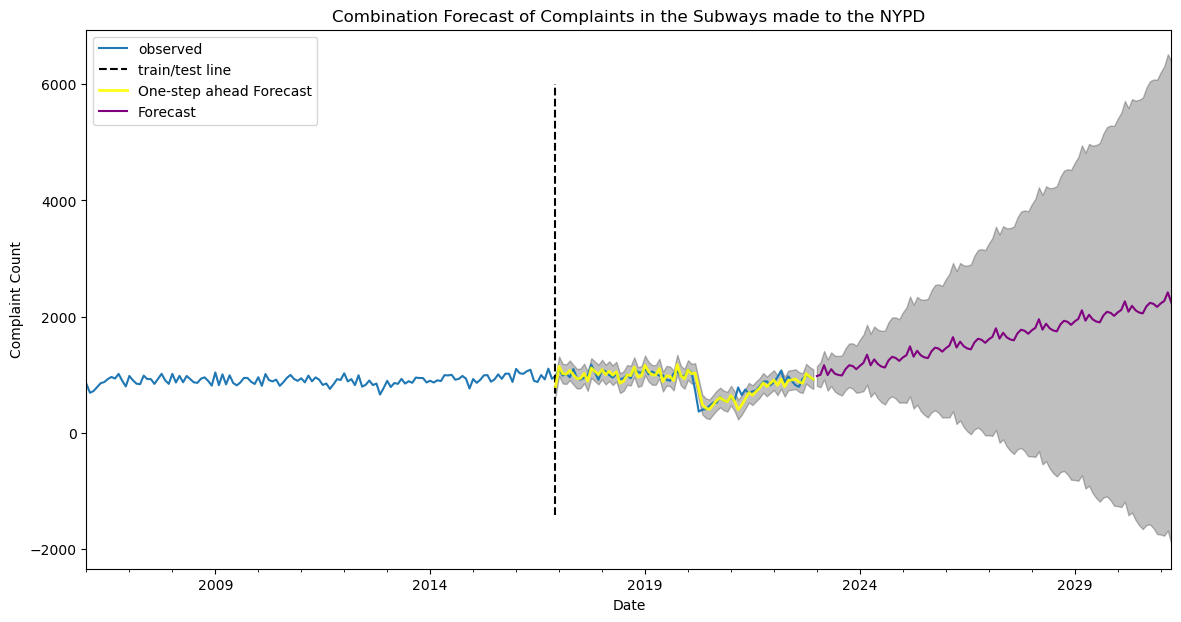

In [85]:
pred = results.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2006-01-01':].plot(label='observed')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
#ax = y.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDOSAandForecast.png', bbox_inches='tight')
plt.show()

## Model 2 
- Jan 1, 2006 through Dec 31, 2019; does not include COVID-19

In [86]:
y2 = df3_monthly['MCC']

In [87]:
y2['2018'].head()

Month
2018-01-31    1083
2018-02-28    1057
2018-03-31     994
2018-04-30     950
2018-05-31    1015
Name: MCC, dtype: int64

<Figure size 1800x800 with 0 Axes>

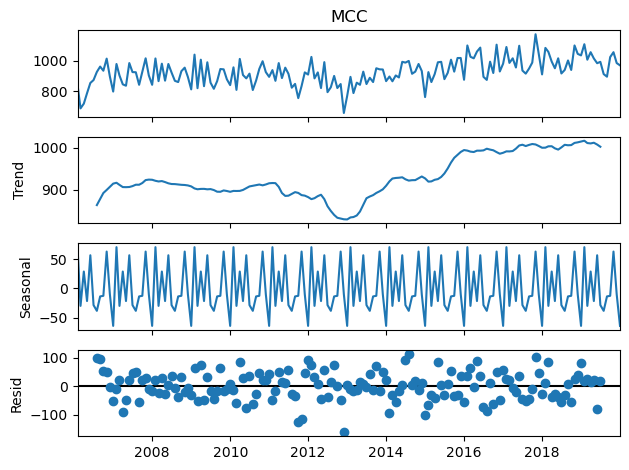

In [88]:
plt.figure(figsize=(18,8))
decomposition = sm.tsa.seasonal_decompose(y2, model='additive')
fig = decomposition.plot()
#plt.savefig('Decomposition2.png', bbox_inches='tight')
plt.show()

In [89]:
def ad_test(data):
    dftest=adfuller(data,autolag='AIC')
    print('1. ADF:',dftest[0])
    print('2. P-Value:',dftest[1])
    print('3. Number of lags:',dftest[2])
    print('4. Number of observations',dftest[3])
    print('5. Critical Values:')
    for key,val in dftest[4].items():
        print('\t',key,':',val)
        
ad_test(df3_monthly['MCC'])

1. ADF: -1.1099466217798157
2. P-Value: 0.7110890508981289
3. Number of lags: 12
4. Number of observations 155
5. Critical Values:
	 1% : -3.4732590518613002
	 5% : -2.880374082105334
	 10% : -2.5768120811654525


In [90]:
# a second test to determine seasonality

from scipy.stats import kruskal

def seasonality_test(series):
        seasonal = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

seasonality_test(y2)

True

In [91]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results2 = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results2.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2759.687199942615
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2389.105460471028
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1785.4105506103253
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1630.472638638746
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1799.5252747064492
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1770.1116067962885
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1645.515213528694
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1629.7277201306454
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2554.641433286726
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2214.6451768584493
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1753.2237202805532
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1607.2554989180812
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1804.2040304934103
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1738.885155769246
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1633.8891813246764
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1604.3235196221383
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1987.2304607661795
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1803.474788973265

In [92]:
mod = sm.tsa.statespace.SARIMAX(y2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results2 = mod.fit()
print(results2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 MCC   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -876.773
Date:                             Fri, 03 May 2024   AIC                           1761.546
Time:                                     15:45:56   BIC                           1773.719
Sample:                                 01-31-2006   HQIC                          1766.490
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2815      0.105      2.692      0.007       0.077       0.486
ma.L1         -0.9024      

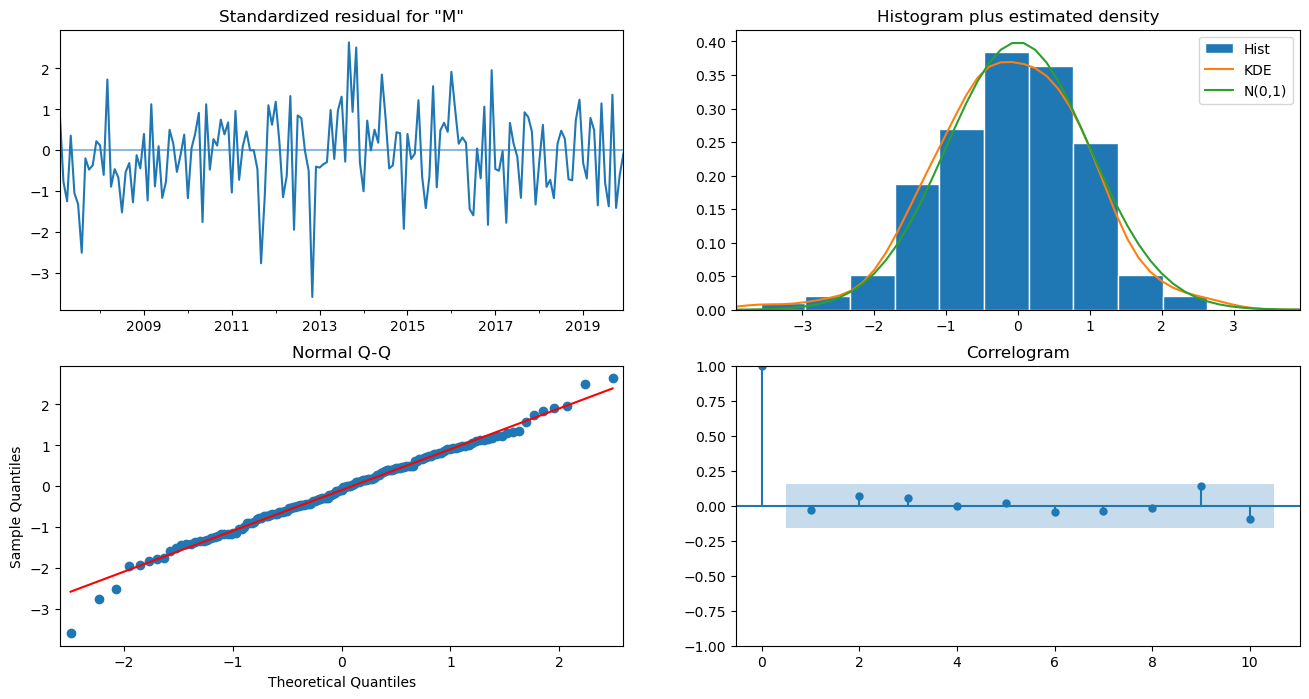

In [93]:
results2.plot_diagnostics(figsize=(16, 8))
plt.show()

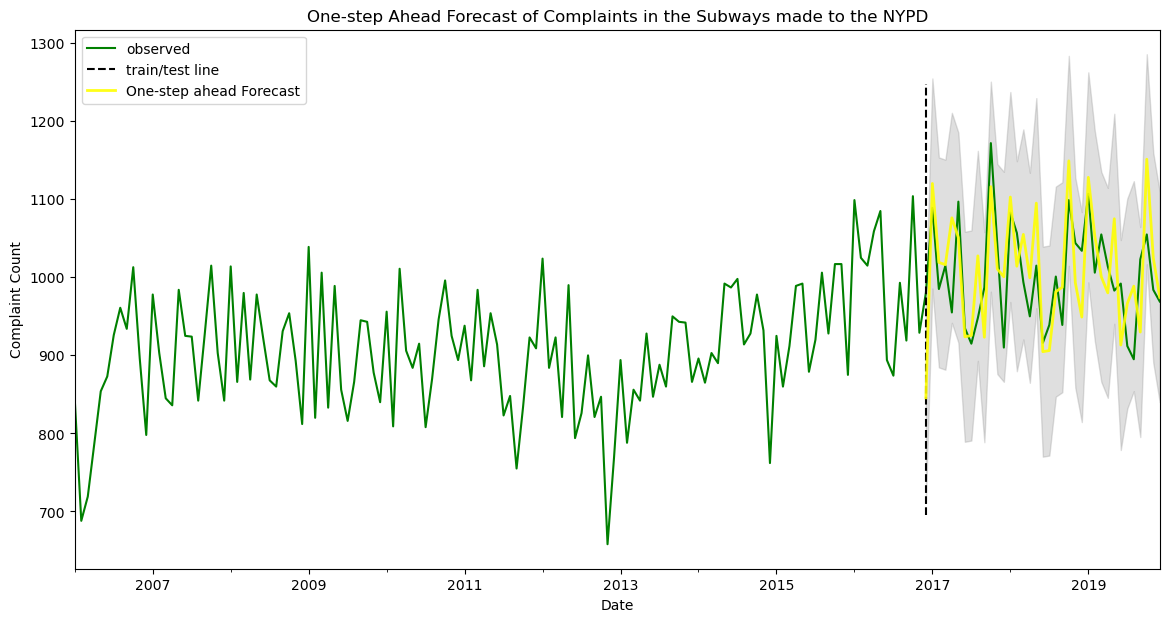

In [94]:
pred = results2.get_prediction(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y2['2006-01-01':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('One-step Ahead Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidOSAF.png', bbox_inches='tight')
plt.show()

In [95]:
y_forecasted = pred.predicted_mean
y_truth = y2['2016-12-31':'2019-12-31']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 3887.26
The Root Mean Squared Error of our forecasts is 62.35


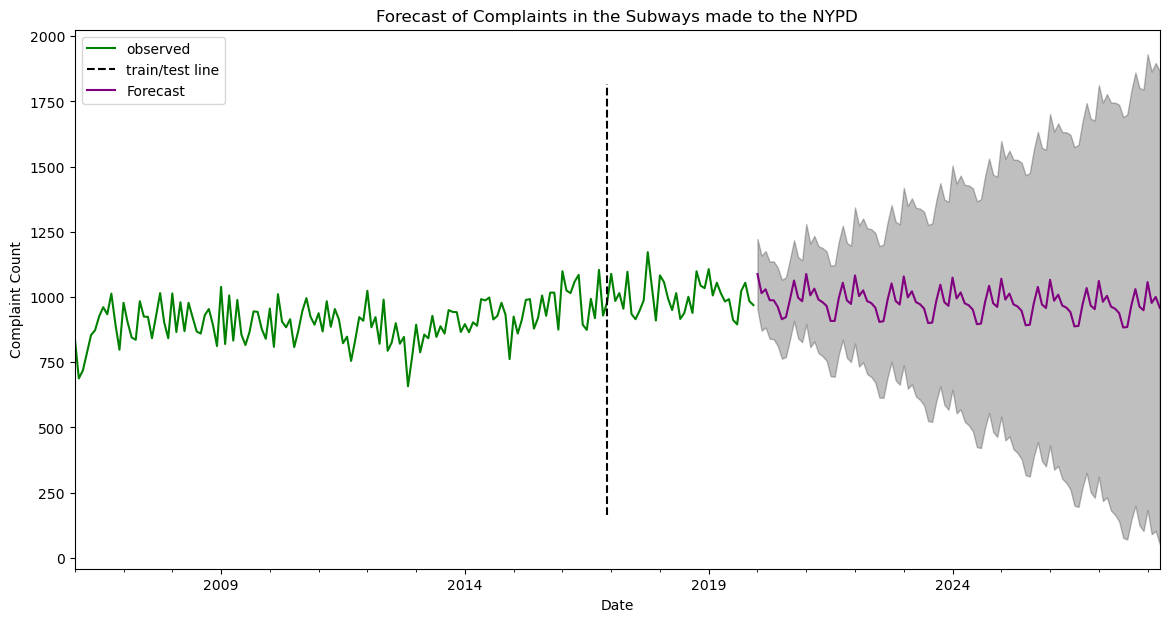

In [96]:
pred_uc = results2.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y2.plot(label='observed', figsize=(14, 7), color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidForecast.png', bbox_inches='tight')
plt.show()

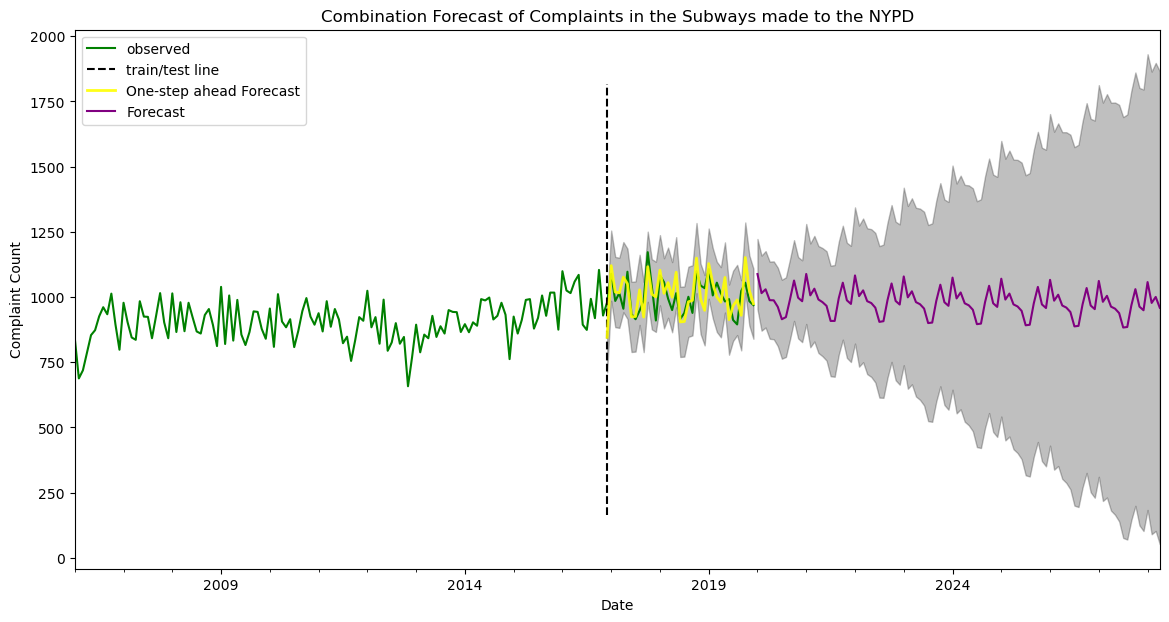

In [97]:
pred = results2.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y2['2006-01-01':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results2.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
#ax = y2.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidOSAFForecast.png', bbox_inches='tight')
plt.show()

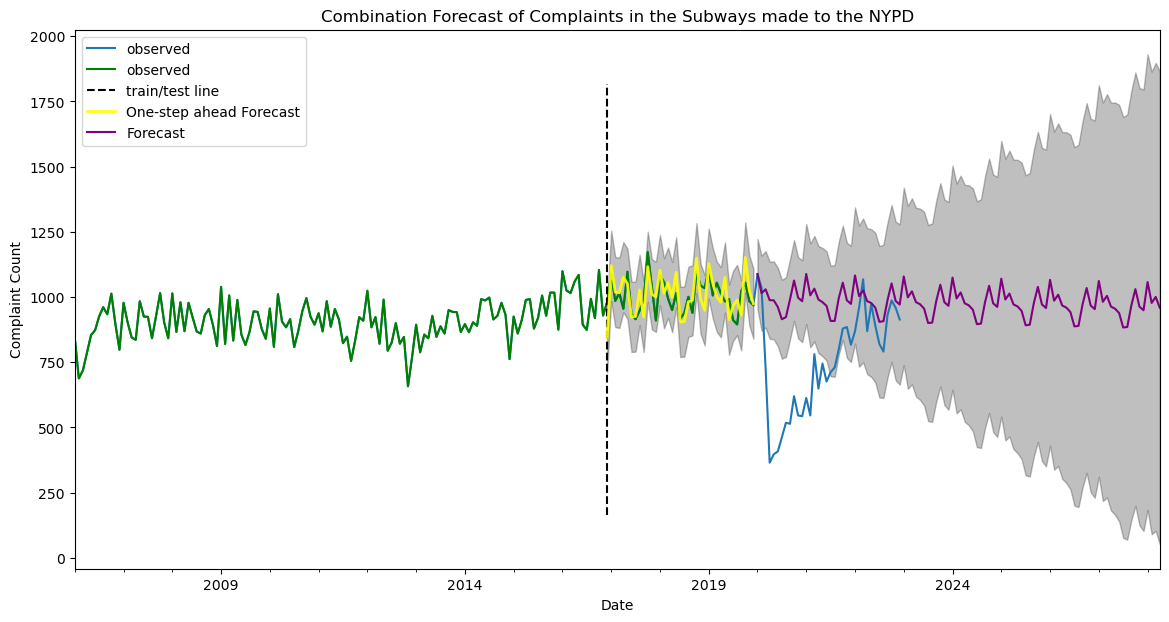

In [98]:
pred = results2.get_prediction(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2006-01-01':].plot(label='observed')
ax = y2['2006':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results2.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
#ax = y.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSCombination.png', bbox_inches='tight')
plt.show()

## Model 3
- Jan 1, 2006 through 12/31/2022, INCLUDING COVID-19

In [99]:
y3 = df2_daily['DCC']

In [100]:
y3['2018'].head(5)

Day
2018-01-01    21
2018-01-02    32
2018-01-03    47
2018-01-04    16
2018-01-05    35
Name: DCC, dtype: int64

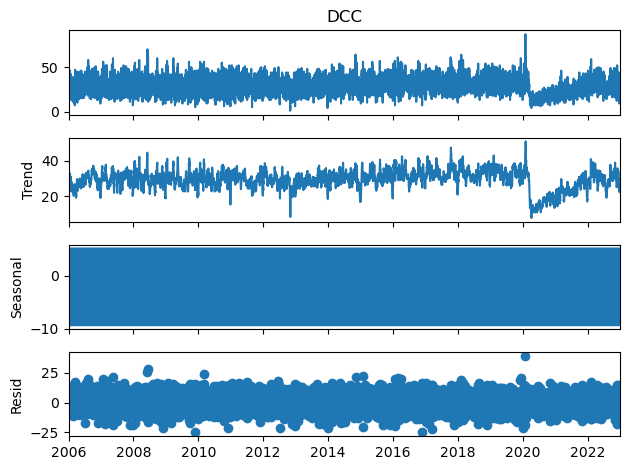

In [101]:
decomposition = sm.tsa.seasonal_decompose(y3, model='additive')
decomposition.plot()
#plt.savefig('Decomposition1.png', bbox_inches='tight')
plt.show()

In [102]:
def ad_test(data):
    dftest=adfuller(data,autolag='AIC')
    print('1. ADF:',dftest[0])
    print('2. P-Value:',dftest[1])
    print('3. Number of lags:',dftest[2])
    print('4. Number of observations',dftest[3])
    print('5. Critical Values:')
    for key,val in dftest[4].items():
        print('\t',key,':',val)
        
ad_test(df2_daily['DCC'])

1. ADF: -5.717205102846517
2. P-Value: 7.075756065877473e-07
3. Number of lags: 34
4. Number of observations 6174
5. Critical Values:
	 1% : -3.431409608180226
	 5% : -2.8620082518350323
	 10% : -2.5670192476469817


In [103]:
# a second test to determine seasonality

from scipy.stats import kruskal

def seasonality_test(series):
        seasonal = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

seasonality_test(y3)

True

In [104]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results3 = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results3.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:60262.42521894464
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:55198.2152336782
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:49547.79096104427
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:45335.36142407659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:49276.70873378121
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:45430.84906360703
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:48270.65813147178
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:45322.74172131944
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:54598.41290446672
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:51892.956309855195
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:48703.757448494194
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:44342.45044411541
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:48267.10399654432
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:45613.262868938866
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:47145.90200715729
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:44327.242751451224
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:46459.78365973235
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:46266.975482508664
ARIMA(

In [105]:
mod = sm.tsa.statespace.SARIMAX(y3,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results3 = mod.fit()
print(results3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 DCC   No. Observations:                 6209
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood              -23670.636
Date:                             Fri, 03 May 2024   AIC                          47349.271
Time:                                     15:48:38   BIC                          47376.198
Sample:                                 01-01-2006   HQIC                         47358.607
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3944      0.012     33.398      0.000       0.371       0.418
ma.L1         -1.0000      

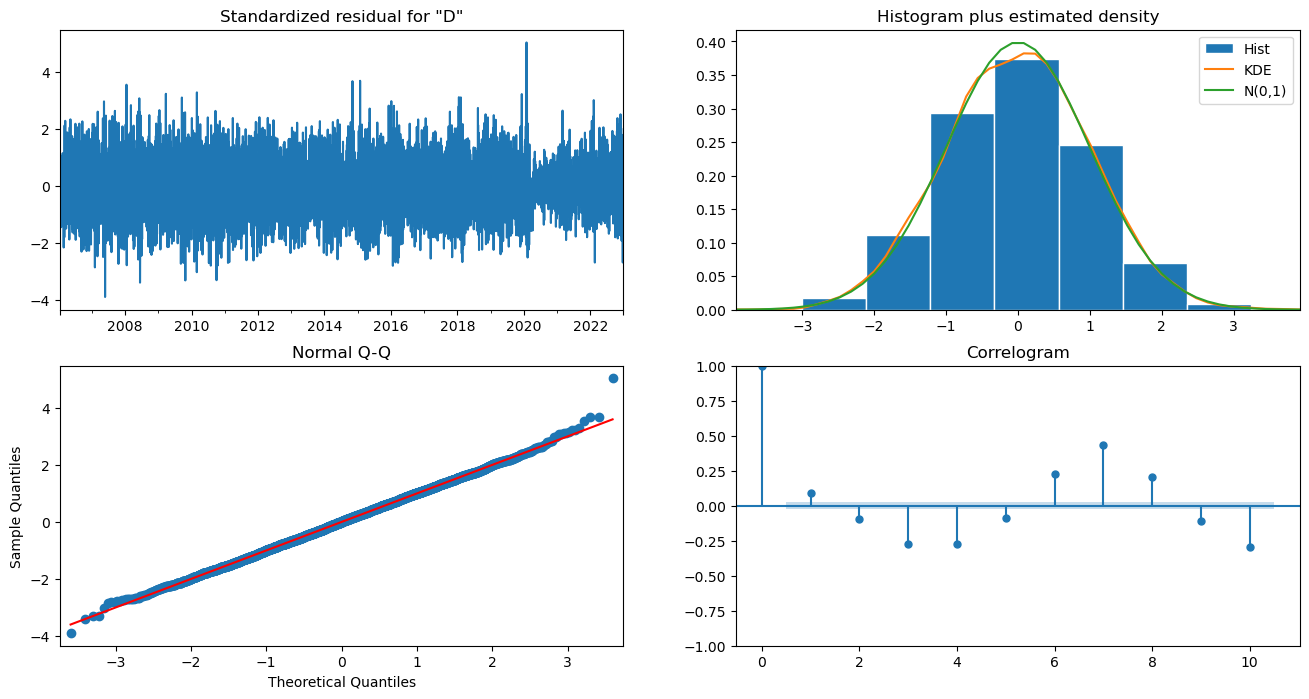

In [106]:
results3.plot_diagnostics(figsize=(16, 8))
plt.show()

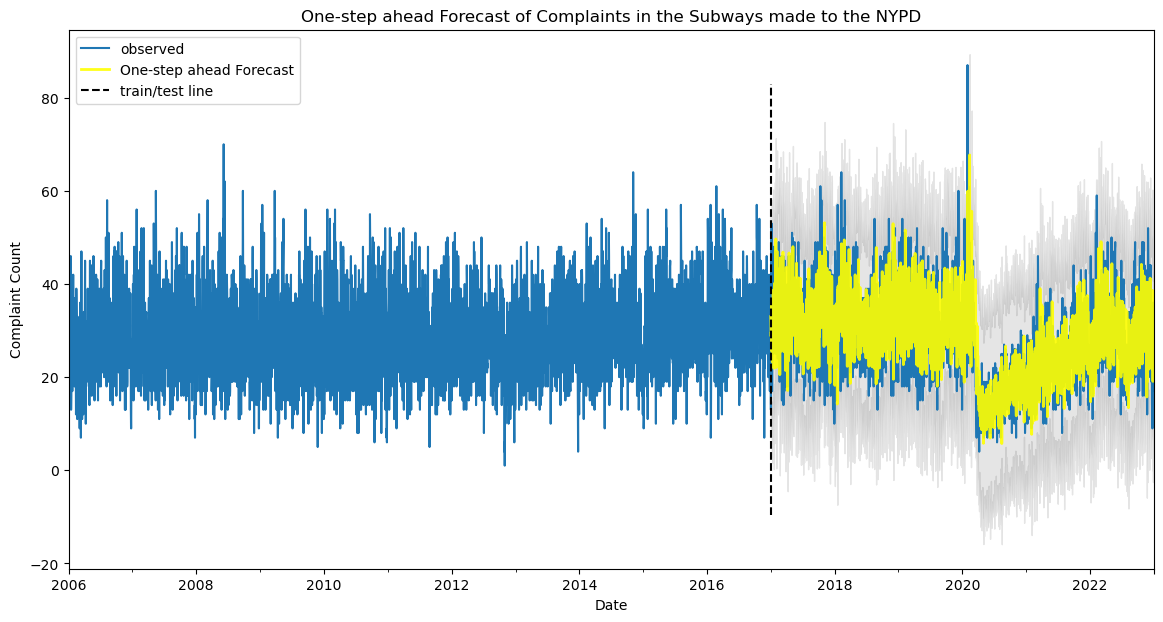

In [107]:
pred = results3.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y3['2006-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.10)
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('One-step ahead Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDOSAF.png', bbox_inches='tight')
plt.show()

In [108]:
y_forecasted = pred.predicted_mean
y_truth = y3['2016-12-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 3)))

The Mean Squared Error of our forecasts is 99.206
The Root Mean Squared Error of our forecasts is 9.96


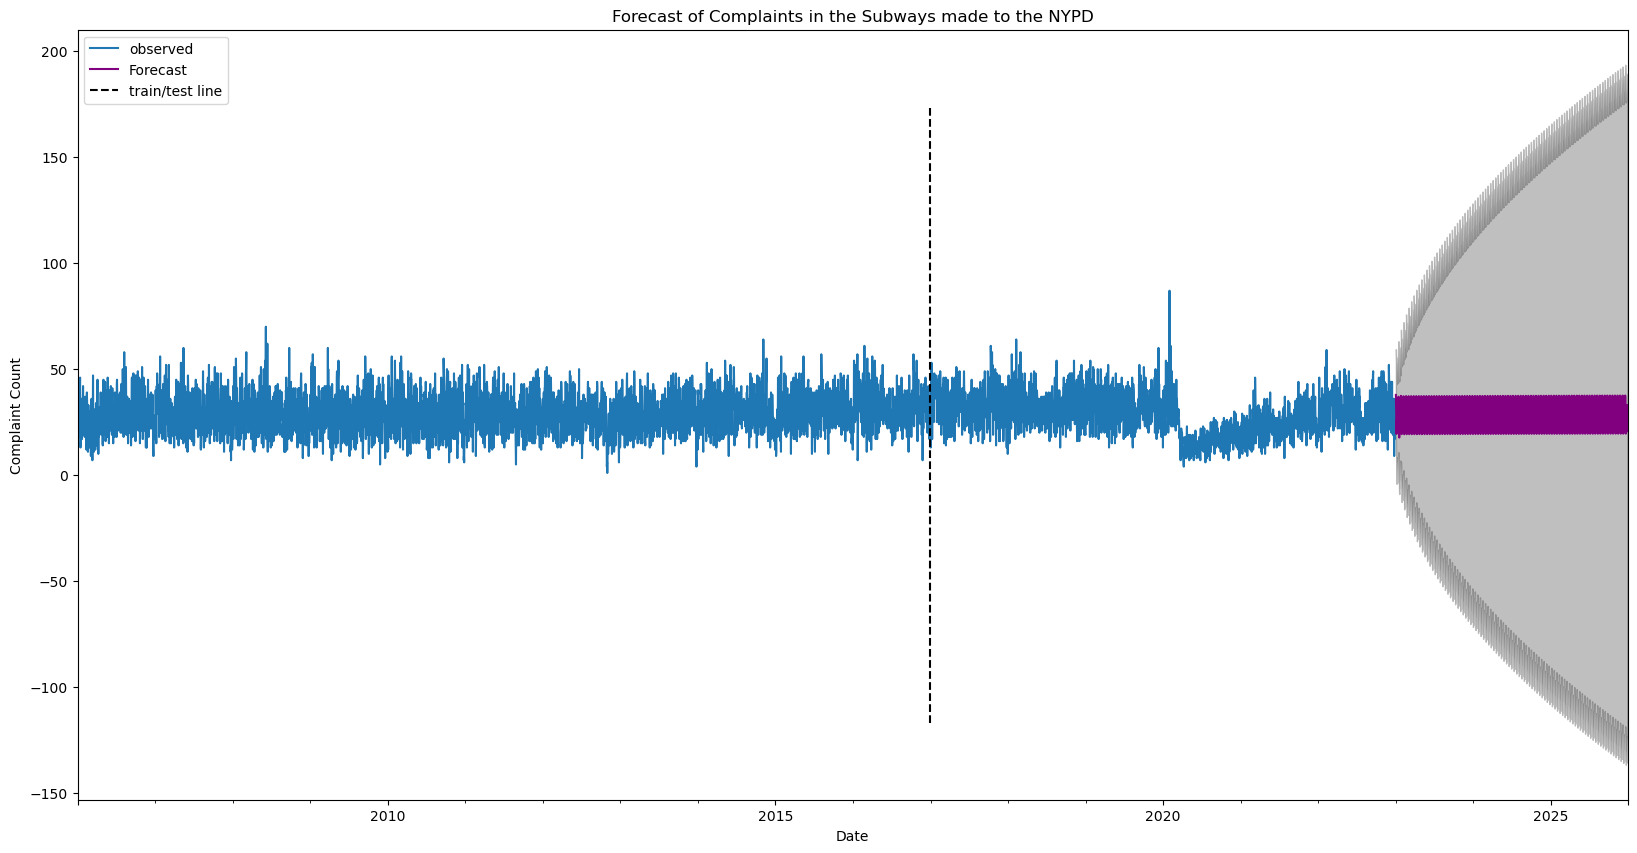

In [109]:
pred_uc = results3.get_forecast(steps=1092)
pred_ci = pred_uc.conf_int()
ax = y3.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDForecast.png', bbox_inches='tight')
plt.show()

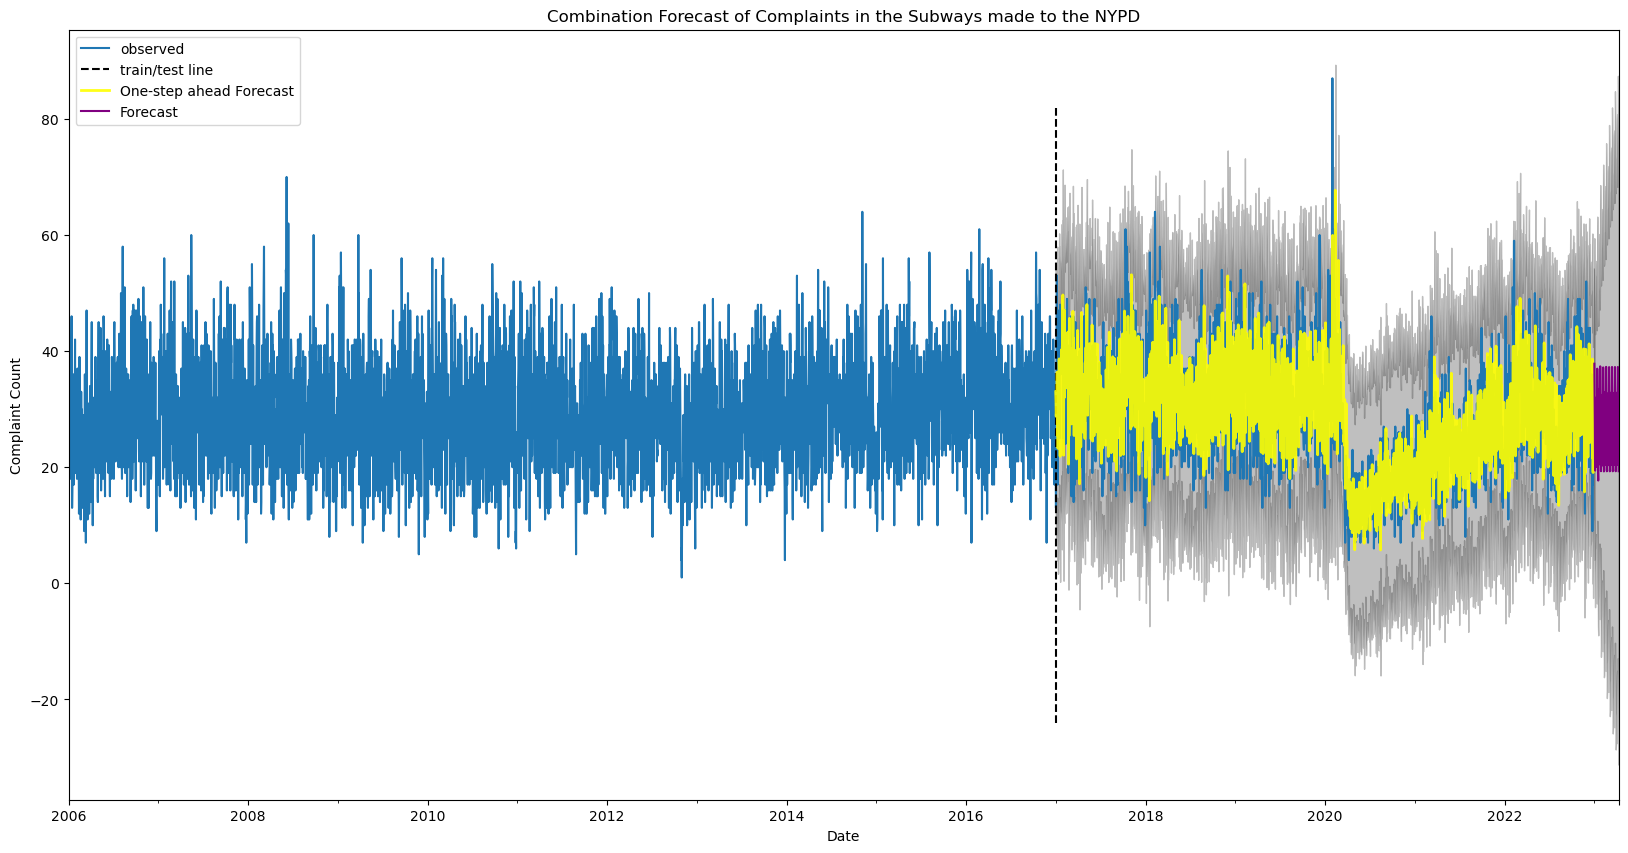

In [110]:
pred = results3.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y3['2006-01-01':].plot(label='observed')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(20,10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results3.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
#ax = y.plot(label='observed', figsize=(20,10))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSwCOVIDOSAandForecast.png', bbox_inches='tight')
plt.show()

## Model 4 
- Jan 1, 2006 through Dec 31, 2019; does not include COVID-19

In [111]:
y4 = df3_daily['DCC']

In [112]:
y4['2018'].head()

Day
2018-01-01    21
2018-01-02    32
2018-01-03    47
2018-01-04    16
2018-01-05    35
Name: DCC, dtype: int64

<Figure size 1800x800 with 0 Axes>

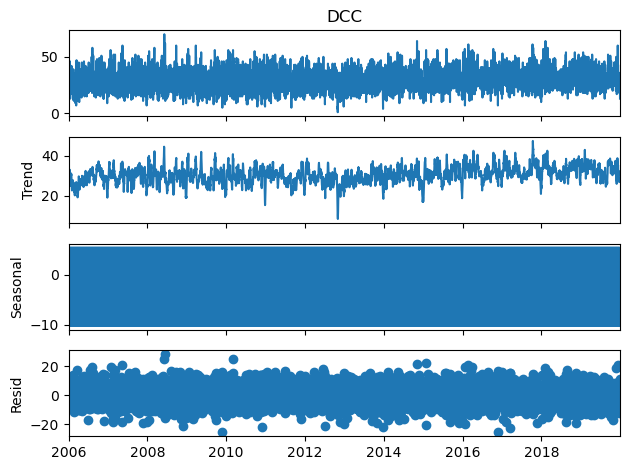

In [113]:
plt.figure(figsize=(18,8))
decomposition = sm.tsa.seasonal_decompose(y4, model='additive')
fig = decomposition.plot()
#plt.savefig('Decomposition2.png', bbox_inches='tight')
plt.show()

In [114]:
def ad_test(data):
    dftest=adfuller(data,autolag='AIC')
    print('1. ADF:',dftest[0])
    print('2. P-Value:',dftest[1])
    print('3. Number of lags:',dftest[2])
    print('4. Number of observations',dftest[3])
    print('5. Critical Values:')
    for key,val in dftest[4].items():
        print('\t',key,':',val)
        
ad_test(df3_daily['DCC'])

1. ADF: -8.312433573843892
2. P-Value: 3.757474385891379e-13
3. Number of lags: 33
4. Number of observations 5079
5. Critical Values:
	 1% : -3.4316381685490334
	 5% : -2.862109233152359
	 10% : -2.56707300316236


In [115]:
# a second test to determine seasonality

from scipy.stats import kruskal

def seasonality_test(series):
        seasonal = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

seasonality_test(y4)

True

In [116]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y4,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results4 = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results4.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:49910.20259697978
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:45722.45042916031
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:41180.59086061418
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:37220.57018747479
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:40954.897741158384
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:37668.835138949915
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:40116.670546301044
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:37179.479650777634
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:45245.98230404193
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:43023.75234051488
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:40465.862465721366
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:36505.926286525886
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:40100.66905079217
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:36573.323392617734
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:39168.10977831452
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:36468.87025977893
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:38583.03797859025
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:38389.63167365994
ARI

In [117]:
mod = sm.tsa.statespace.SARIMAX(y4,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results4 = mod.fit()
print(results4.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 DCC   No. Observations:                 5113
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood              -19678.274
Date:                             Fri, 03 May 2024   AIC                          39364.549
Time:                                     15:51:17   BIC                          39390.697
Sample:                                 01-01-2006   HQIC                         39373.704
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3972      0.014     29.156      0.000       0.370       0.424
ma.L1         -1.0000      

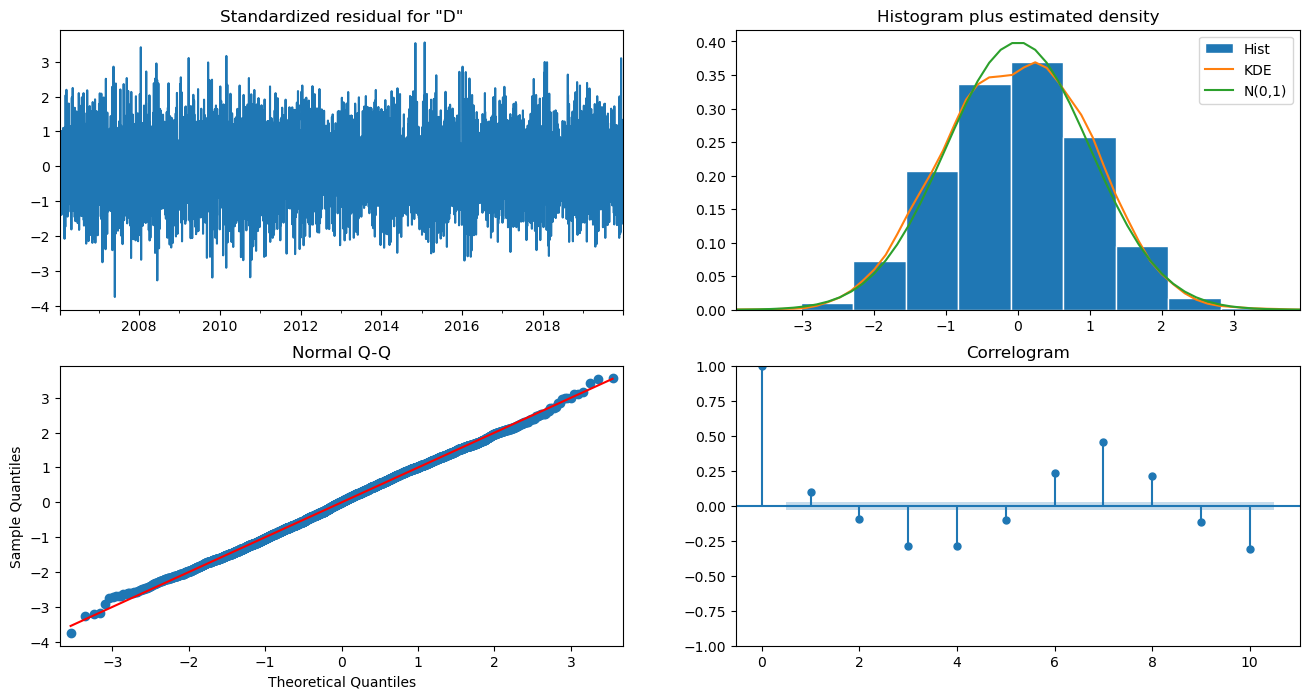

In [118]:
results4.plot_diagnostics(figsize=(16, 8))
plt.show()

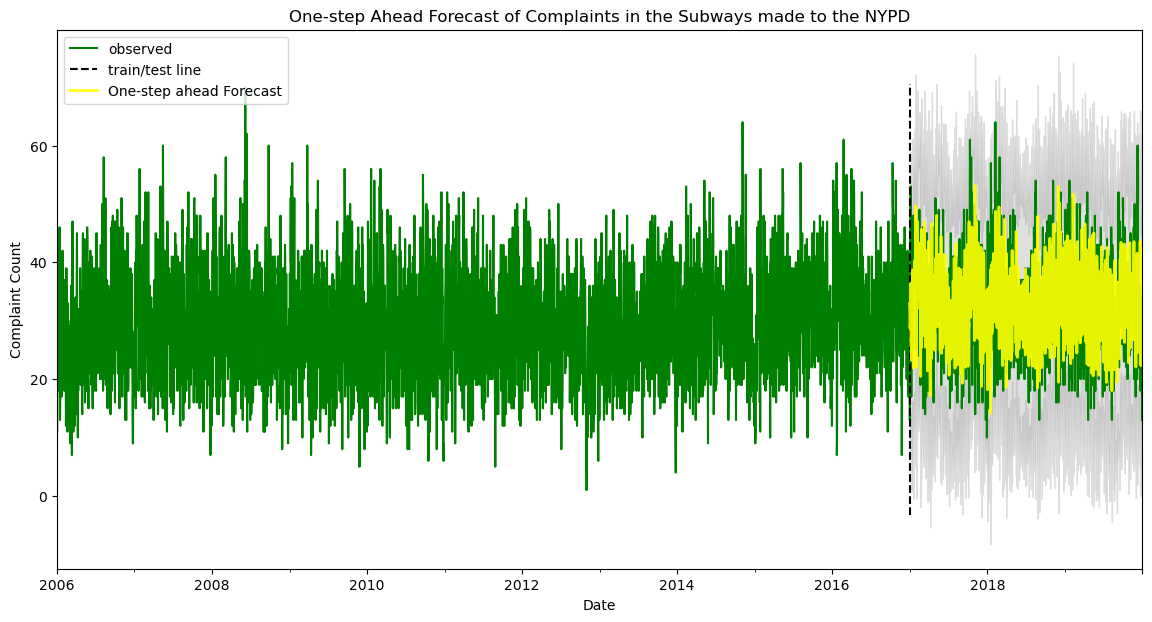

In [119]:
pred = results4.get_prediction(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y4['2006-01-01':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('One-step Ahead Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidOSAF.png', bbox_inches='tight')
plt.show()

In [120]:
y_forecasted = pred.predicted_mean
y_truth = y4['2016-12-31':'2019-12-31']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 3)))

The Mean Squared Error of our forecasts is 121.503
The Root Mean Squared Error of our forecasts is 11.023


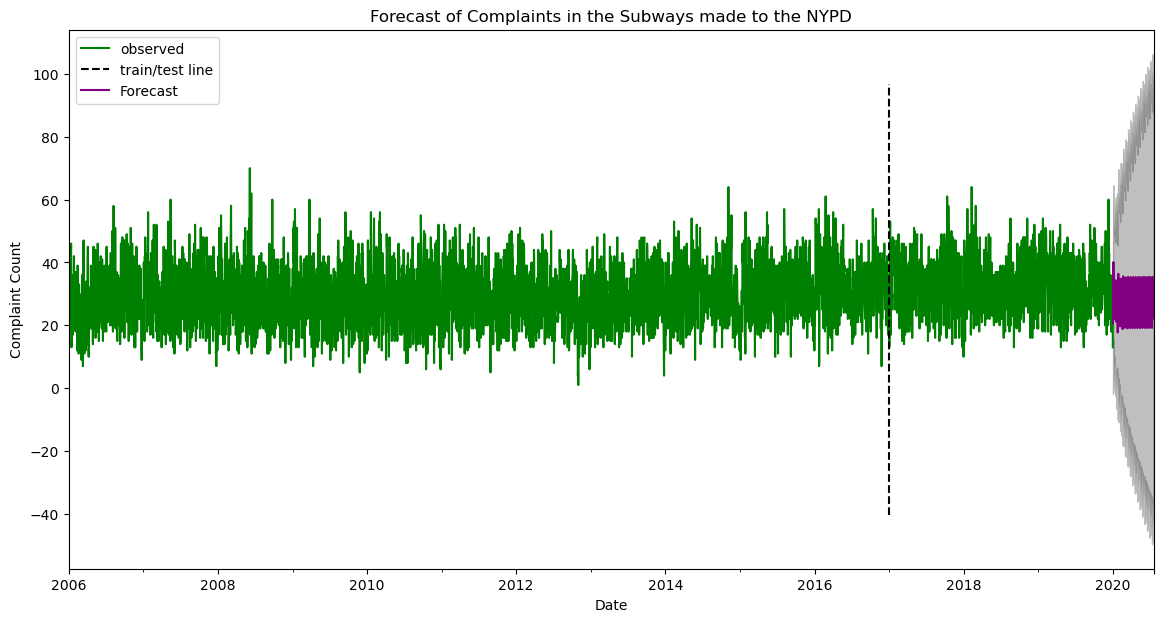

In [121]:
pred_uc = results4.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = y4.plot(label='observed', figsize=(14, 7), color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidForecast.png', bbox_inches='tight')
plt.show()

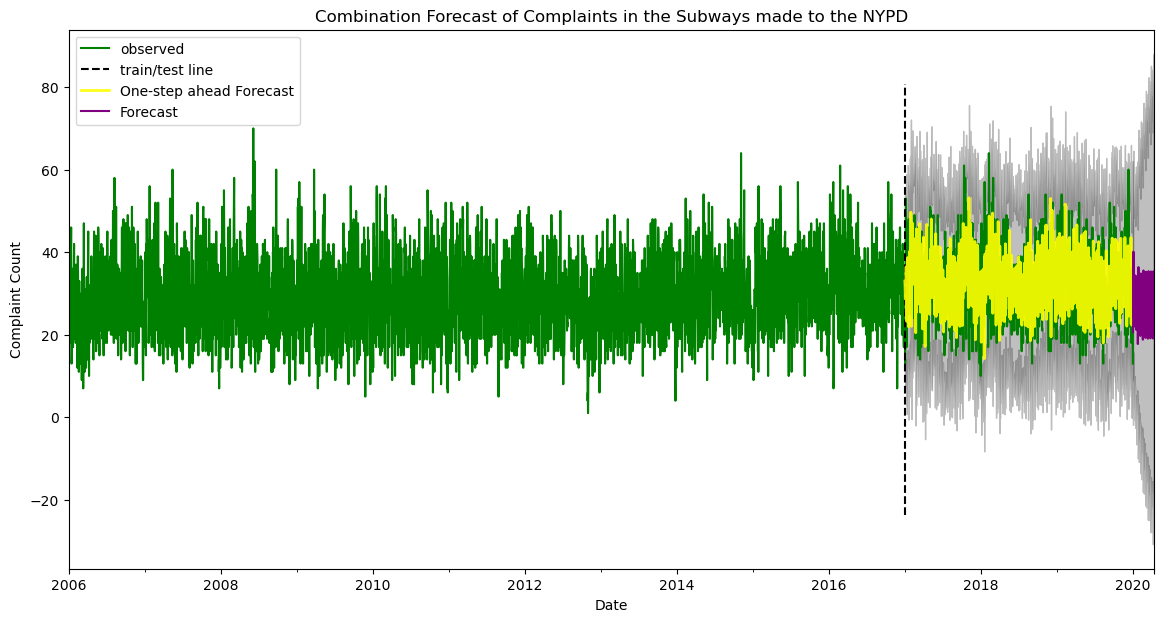

In [122]:
pred = results4.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y4['2006-01-01':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results4.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
#ax = y2.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSnoCovidOSAFForecast.png', bbox_inches='tight')
plt.show()

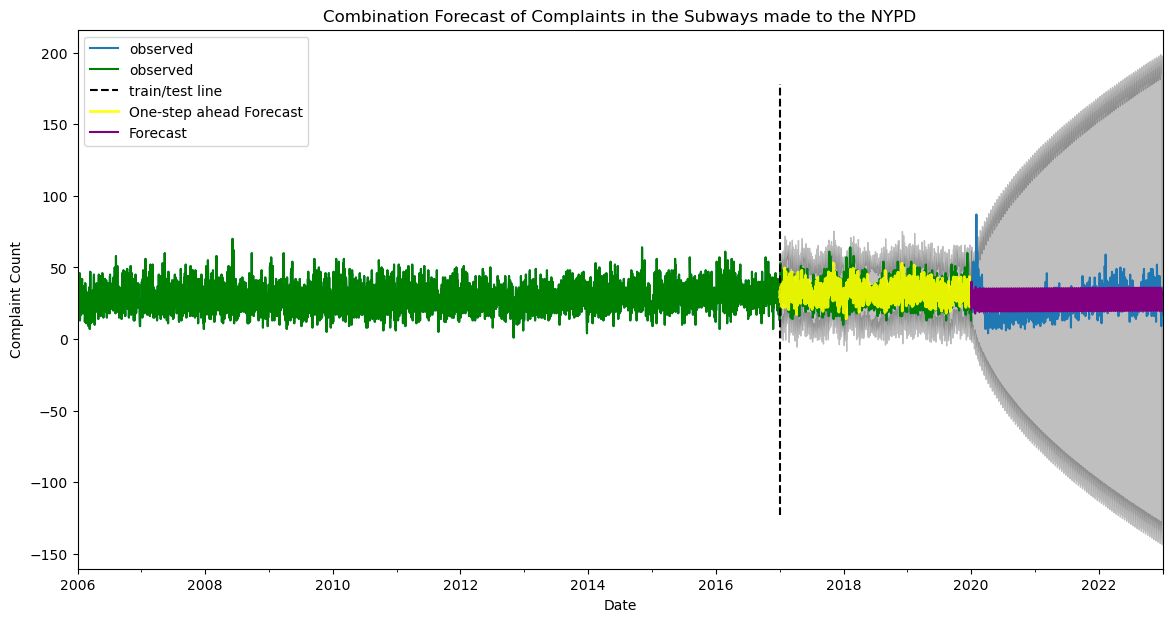

In [123]:
pred = results4.get_prediction(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y3['2006-01-01':].plot(label='observed')
ax = y4['2006':].plot(label='observed', color = 'green')
plt.axvline(x = '2016-12-31', ymin = 0.1, ymax = 0.90, color = 'black', linestyle = '--', label = 'train/test line')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'yellow', alpha=.9, linewidth = 2, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
pred_uc = results4.get_forecast(steps=1092)
pred_ci = pred_uc.conf_int()
#ax = y.plot(label='observed', figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax, color = 'purple', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
plt.title('Combination Forecast of Complaints in the Subways made to the NYPD')
plt.legend(loc = 'upper left')
#plt.savefig('TSCombination.png', bbox_inches='tight')
plt.show()

## XGBoost

## Model 1
- df4: Jan 1, 2006 through 12/31/2019, EXCLUDING COVID-19

In [124]:
df4 = data1[['DATETIME']]
df4.tail()

DATETIME
155863 2019-12-31 17:30:00
155864 2019-12-31 06:00:00
155865 2019-12-31 20:45:00
155866 2019-12-31 21:10:00
155867 2019-12-31 20:00:00

In [125]:
df4.isnull().sum()

DATETIME    0
dtype: int64

In [126]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155868 entries, 0 to 155867
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   DATETIME  155868 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 MB


In [127]:
df4.index = pd.to_datetime(df4.DATETIME, format = '%Y-%m-%d')
del df4['DATETIME']

After trial and error, determined it was best to work with Daily Complaints data

In [128]:
df4_daily = pd.DataFrame(df4.resample('D').size().reset_index())
df4_daily.columns = ['Day', 'DCC']
df4_daily.index = pd.to_datetime(df4_daily.Day, format = '%Y-%m-%d')
del df4_daily['Day']
df4_daily.tail()

DCC
Day            
2019-12-27   31
2019-12-28   34
2019-12-29   29
2019-12-30   33
2019-12-31   13

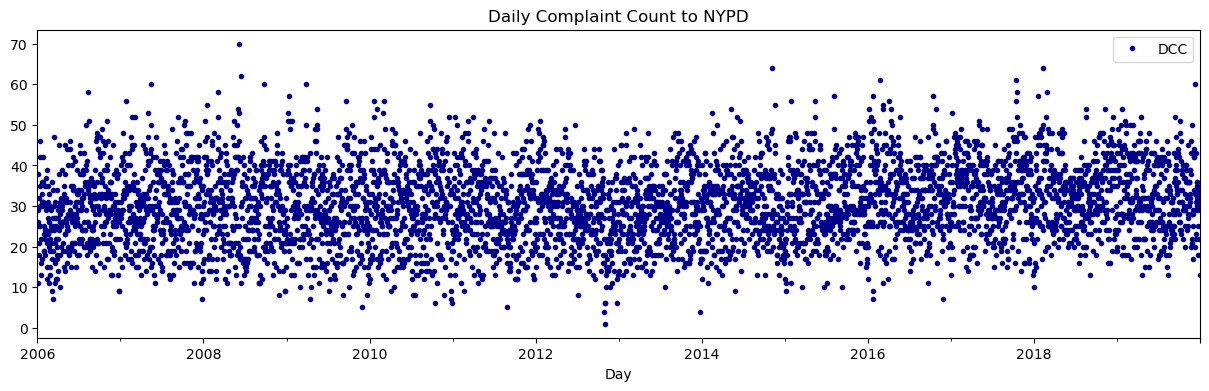

In [129]:
df4_daily.plot(style='.',
                figsize=(15,4),
                color = 'darkblue',
                title= 'Daily Complaint Count to NYPD')
plt.show()

#### Review Outliers and Remove

<Axes: ylabel='Frequency'>

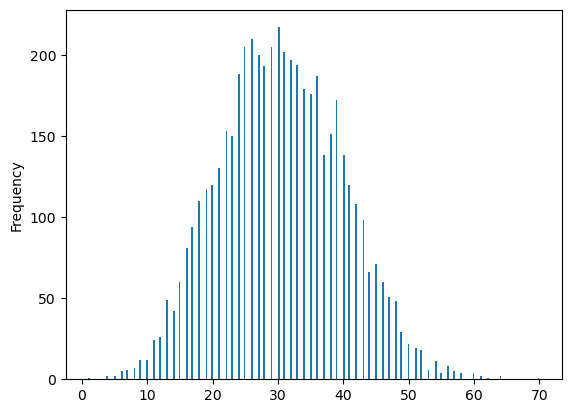

In [130]:
df4_daily['DCC'].plot(kind='hist', bins=250)

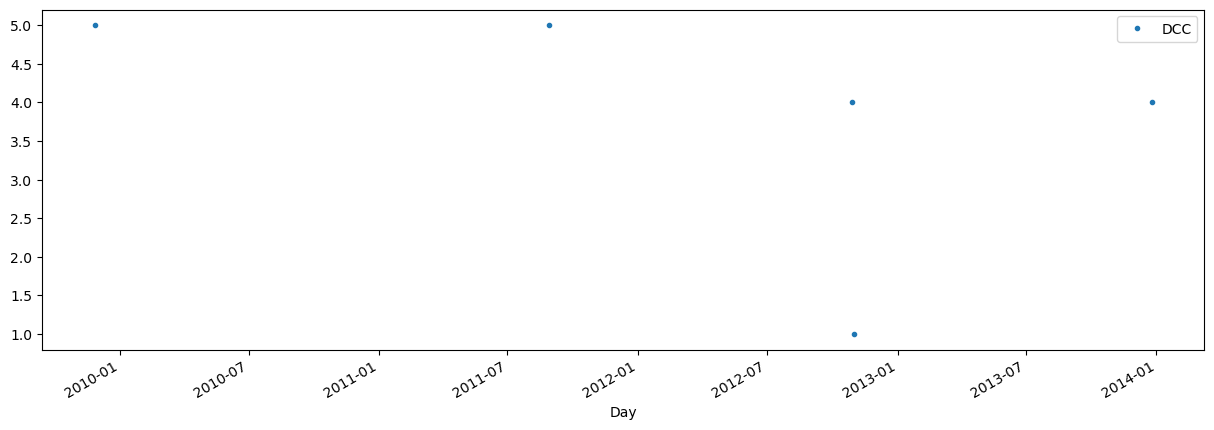

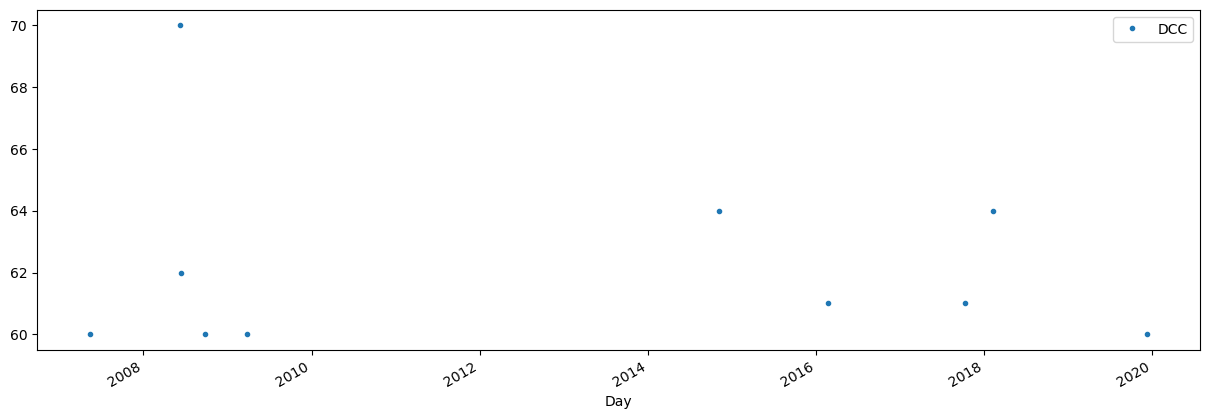

In [131]:
df4_daily.query('DCC < 6').plot(figsize=(15,5), style='.')
df4_daily.query('DCC > 59').plot(figsize=(15,5), style='.')
plt.show()

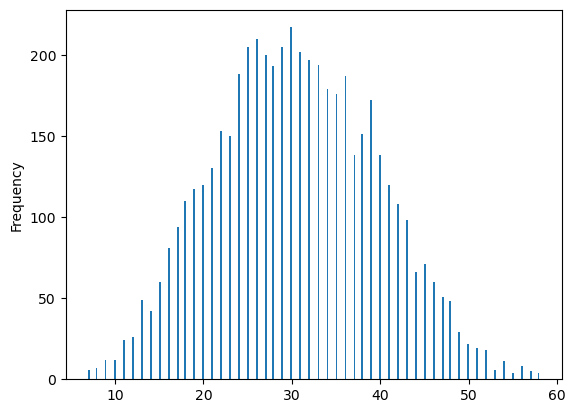

In [132]:
df4_daily = df4_daily.query('DCC > 6').copy()
df4_daily = df4_daily.query('DCC < 59').copy()
df4_daily['DCC'].plot(kind='hist', bins=250)
plt.show()

#### Train/Test Split 

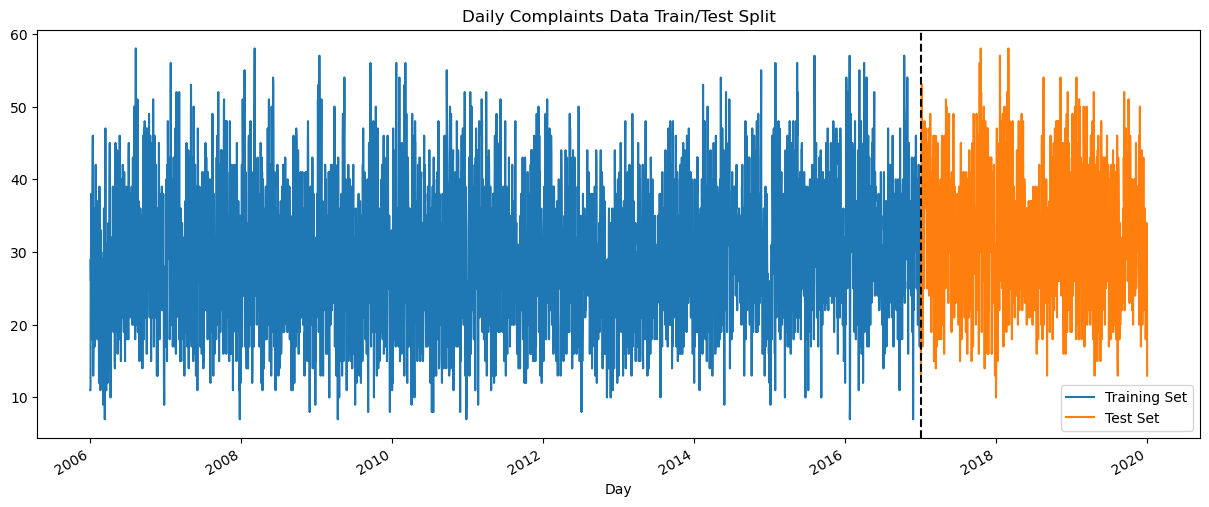

In [133]:
train = df4_daily.loc[df4_daily.index < '2016-12-31']
test = df4_daily.loc[df4_daily.index >= '2016-12-31']

fig, ax = plt.subplots(figsize=(15,6))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set', title = "Daily Complaints Data Train/Test Split")
ax.legend(['Training Set', 'Test Set'])
ax.axvline('2016-12-31', color = 'black', ls = '--')
plt.show()

#### Create date related features

In [134]:
def create_features(df4_daily):
    
    df4_daily = df4_daily.copy()
    df4_daily['dayofweek'] = df4_daily.index.dayofweek
    df4_daily['quarter'] = df4_daily.index.quarter
    df4_daily['month'] = df4_daily.index.month
    df4_daily['year'] = df4_daily.index.year
    df4_daily['dayofyear'] = df4_daily.index.dayofyear
    df4_daily['dayofmonth'] = df4_daily.index.day
    df4_daily['weekofyear'] = df4_daily.index.isocalendar().week
    return df4_daily

df4_daily = create_features(df4_daily)

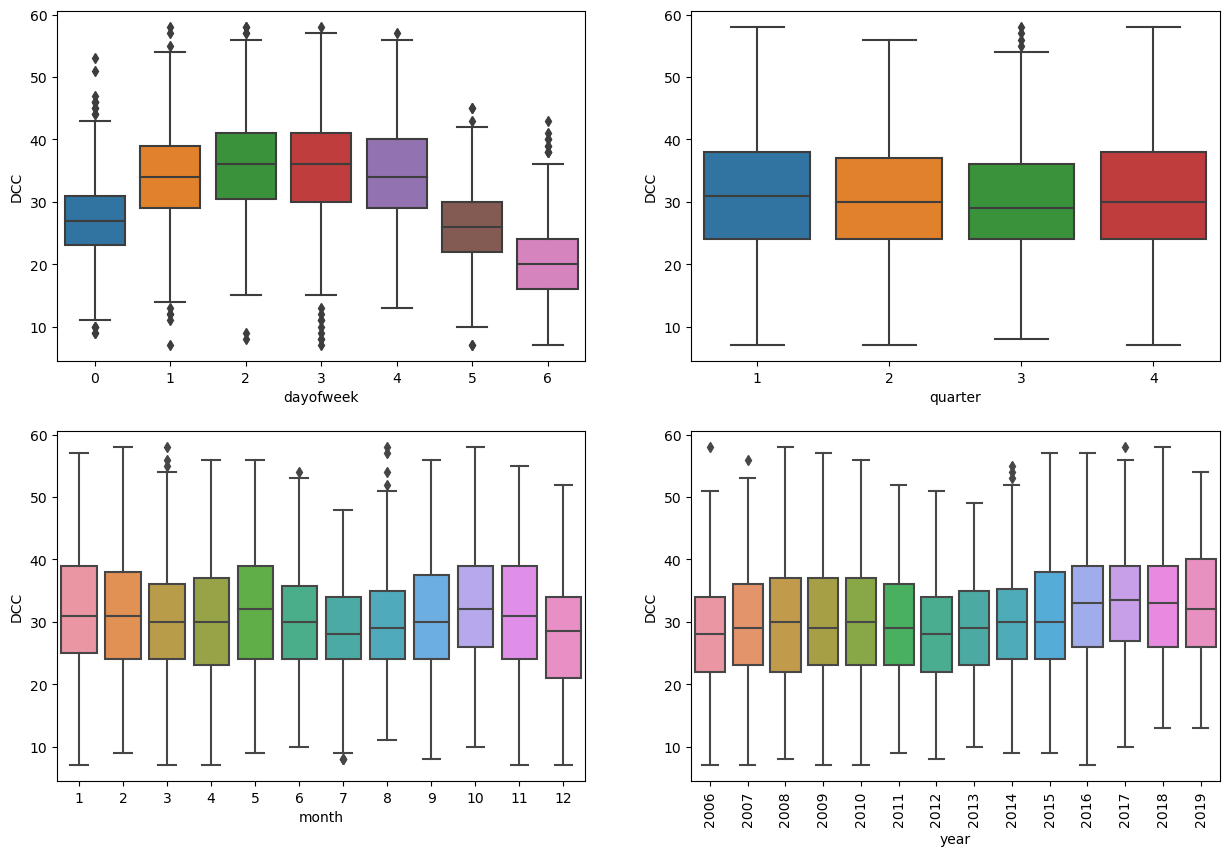

In [135]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df4_daily, x = 'dayofweek', y = 'DCC')
ax.set_title('Complaint Count by Day of the Week')

plt.subplot(2,2,2)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df4_daily, x = 'quarter', y = 'DCC')
ax.set_title('Complaint Count by by Quarter')

plt.subplot(2,2,3)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df4_daily, x = 'month', y = 'DCC')
ax.set_title('Complaint Count by Month')

plt.subplot(2,2,4)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df4_daily, x = 'year', y = 'DCC')
ax.set_title('Complaint Count by Year')
plt.xticks(rotation=90)

plt.show()

- based on boxplots W - F see the highest rates of complaints
- May and October have the highest median value

In [136]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear']
TARGET = 'DCC' 

In [137]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [138]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set =[(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:9.21299	validation_1-rmse:9.16619
[100]	validation_0-rmse:7.01554	validation_1-rmse:7.45069
[200]	validation_0-rmse:6.40702	validation_1-rmse:7.01566
[300]	validation_0-rmse:6.10623	validation_1-rmse:6.90771
[400]	validation_0-rmse:5.86917	validation_1-rmse:6.86721
[488]	validation_0-rmse:5.71946	validation_1-rmse:6.86507


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [139]:
fi = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

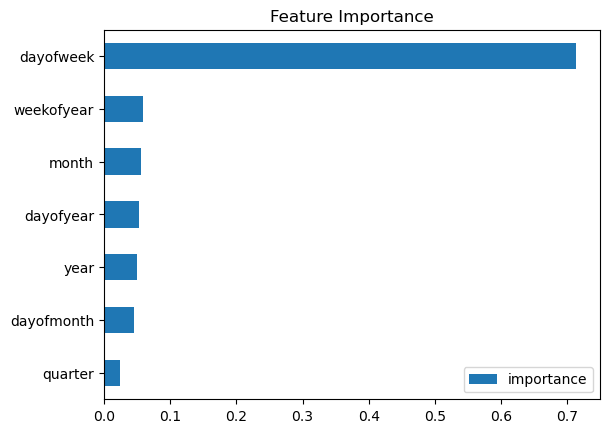

In [140]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.show()

In [141]:
#forecast on test set

test['prediction'] = reg.predict(X_test)

In [142]:
df4_daily = df4_daily.merge(test[['prediction']], how ='left', left_index = True, right_index = True)

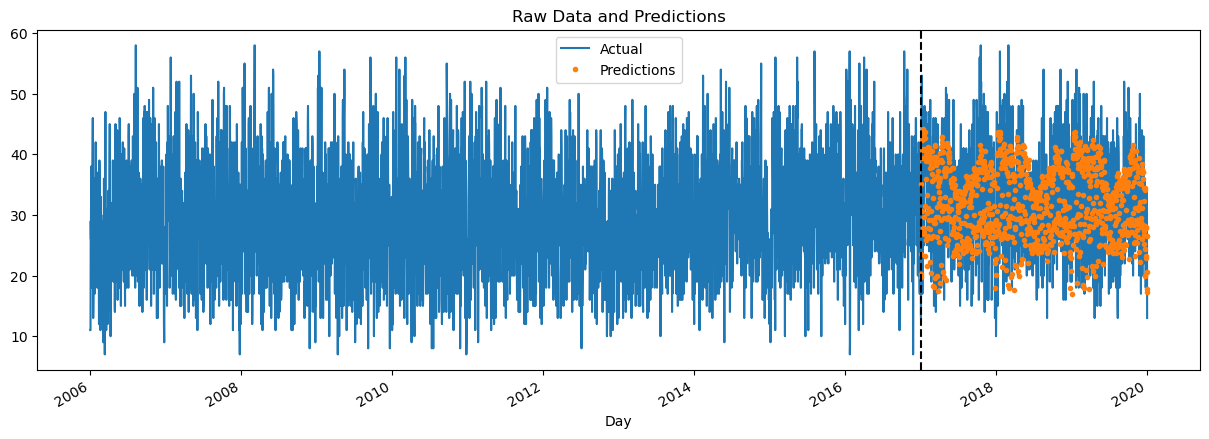

In [143]:
ax = df4_daily[['DCC']].plot(figsize=(15,5))
df4_daily['prediction'].plot(ax=ax, style = '.')
plt.legend(['Actual', 'Predictions'])
ax.set_title('Raw Data and Predictions')
ax.axvline('2016-12-31', color = 'black', ls = '--')
plt.show()

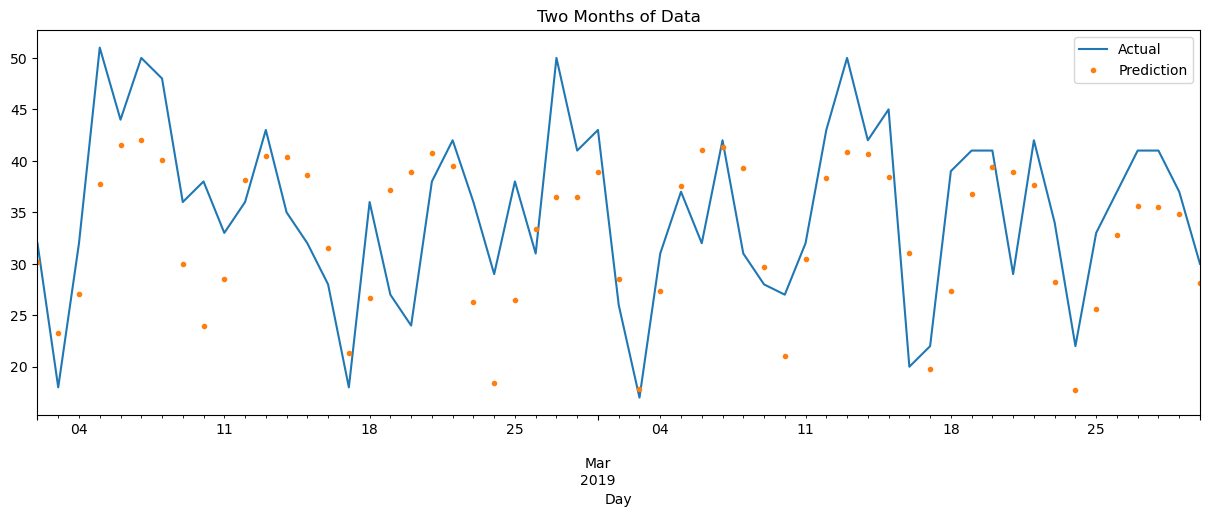

In [144]:
ax = df4_daily.loc[(df4_daily.index > '2019-02-01') & (df4_daily.index < '2019-03-31')]['DCC'].plot(figsize=(15,5), title = 'Two Months of Data')
df4_daily.loc[(df4_daily.index > '2019-02-01') & (df4_daily.index < '2019-03-31')]['prediction'].plot(style = '.')
plt.legend(['Actual', 'Prediction'])

plt.show()

In [145]:
rmse = np.sqrt(mean_squared_error(test['DCC'], test['prediction']))
print(f'RMSE Score on test set: {rmse:0.2f}')

RMSE Score on test set: 6.86


In [146]:
# Calculate Error - look at the worst and best predicted days

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
print("Top 5 RMSE errors: ")
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

Top 5 RMSE errors: 


date
2017-03-14    24.269760
2018-01-04    23.849400
2017-01-06    22.351688
2018-02-28    21.507915
2017-01-29    19.434202
Name: error, dtype: float64

In [147]:
print("Bottom 5 RMSE errors: ")
test.groupby('date')['error'].mean().sort_values(ascending=False).tail(5)

Bottom 5 RMSE errors: 


date
2019-05-10    0.057953
2018-07-13    0.050610
2017-01-27    0.049229
2019-08-26    0.048483
2017-11-10    0.042282
Name: error, dtype: float64

## Model 2
- Jan 1, 2006 through 12/31/2022,INCLUDING COVID-19

In [148]:
df5 = df[['DATETIME']]
df5.tail()

DATETIME
182949 2022-12-31
182950 2022-12-31
182951 2022-12-31
182952 2022-12-31
182953 2022-12-31

In [149]:
df5.isnull().sum()

DATETIME    0
dtype: int64

In [150]:
df5.index = pd.to_datetime(df5.DATETIME, format = '%Y-%m-%d')
del df5['DATETIME']

In [151]:
df5_daily = pd.DataFrame(df5.resample('D').size().reset_index())
df5_daily.columns = ['Day', 'DCC']
df5_daily.index = pd.to_datetime(df5_daily.Day, format = '%Y-%m-%d')
del df5_daily['Day']
df5_daily.tail()

DCC
Day            
2022-12-27   28
2022-12-28   32
2022-12-29   36
2022-12-30   21
2022-12-31   27

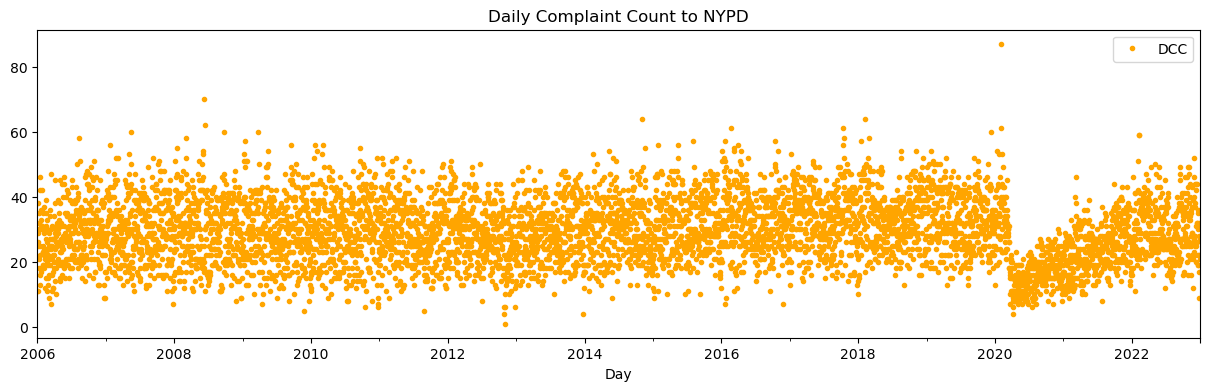

In [152]:
df5_daily.plot(style='.',
                figsize=(15,4),
                color = 'orange',
                title= 'Daily Complaint Count to NYPD')
plt.show()

#### Review Upper Outliers and Remove

<Axes: ylabel='Frequency'>

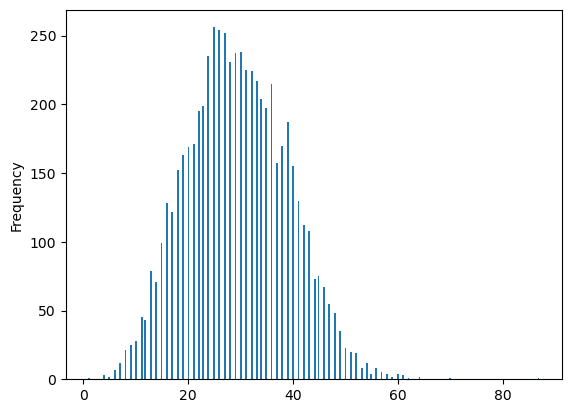

In [153]:
df5_daily['DCC'].plot(kind='hist', bins=250)

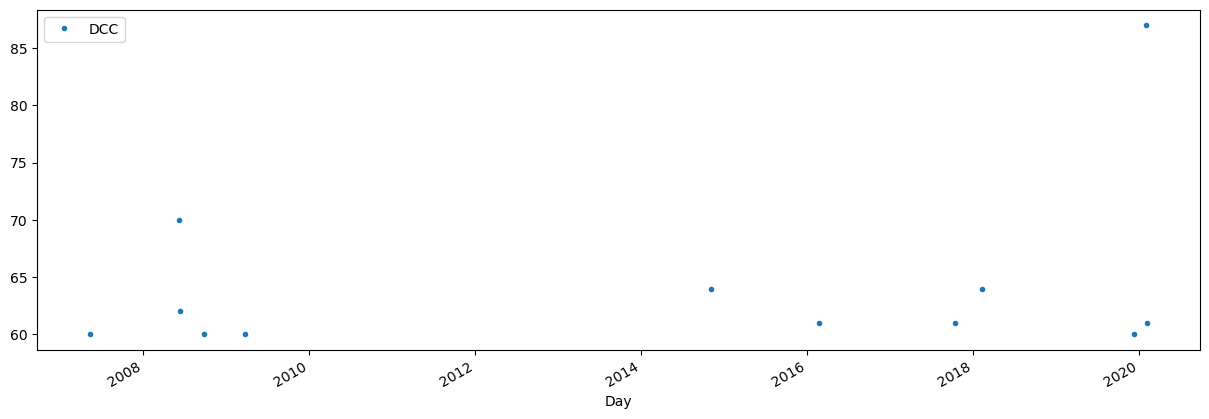

In [154]:
df5_daily.query('DCC > 59').plot(figsize=(15,5), style='.')
plt.show()

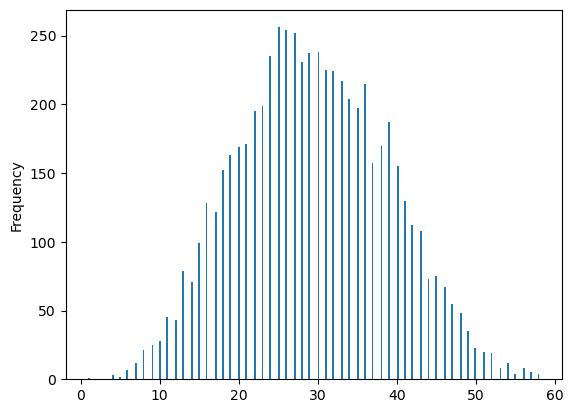

In [155]:
df5_daily = df5_daily.query('DCC < 59').copy()
df5_daily['DCC'].plot(kind='hist', bins=250)
plt.show()

#### Train/Test Split 

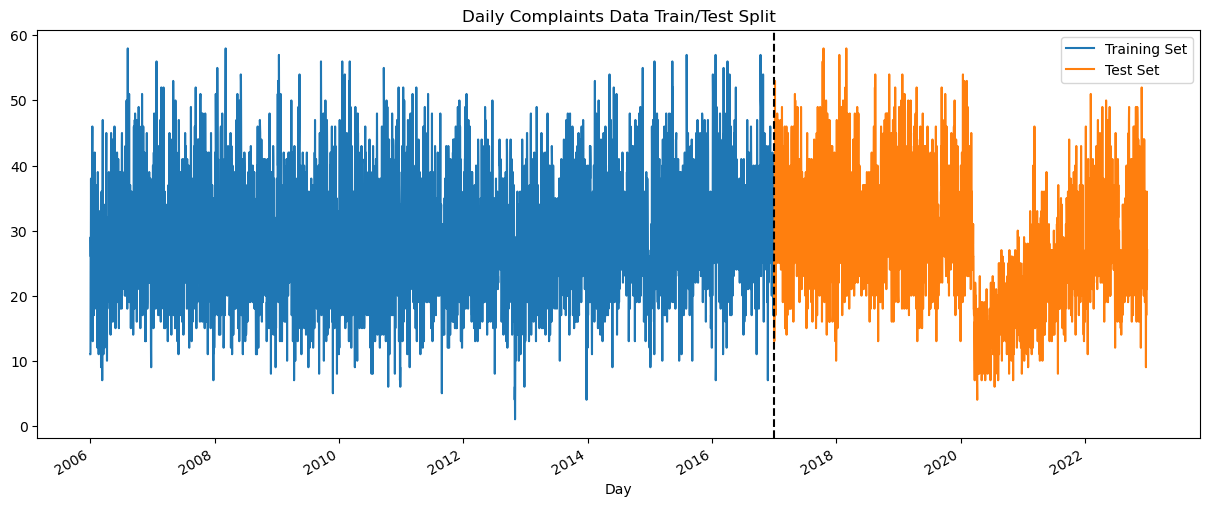

In [156]:
train = df5_daily.loc[df5_daily.index < '2016-12-31']
test = df5_daily.loc[df5_daily.index >= '2016-12-31']

fig, ax = plt.subplots(figsize=(15,6))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set', title = "Daily Complaints Data Train/Test Split")
ax.legend(['Training Set', 'Test Set'])
ax.axvline('2016-12-31', color = 'black', ls = '--')
plt.show()

In [157]:
def create_features1(df5_daily):
    
    df5_daily = df5_daily.copy()
    df5_daily['dayofweek'] = df5_daily.index.dayofweek
    df5_daily['quarter'] = df5_daily.index.quarter
    df5_daily['month'] = df5_daily.index.month
    df5_daily['year'] = df5_daily.index.year
    df5_daily['dayofyear'] = df5_daily.index.dayofyear
    df5_daily['dayofmonth'] = df5_daily.index.day
    df5_daily['weekofyear'] = df5_daily.index.isocalendar().week
    return df5_daily

df5_daily = create_features1(df5_daily)

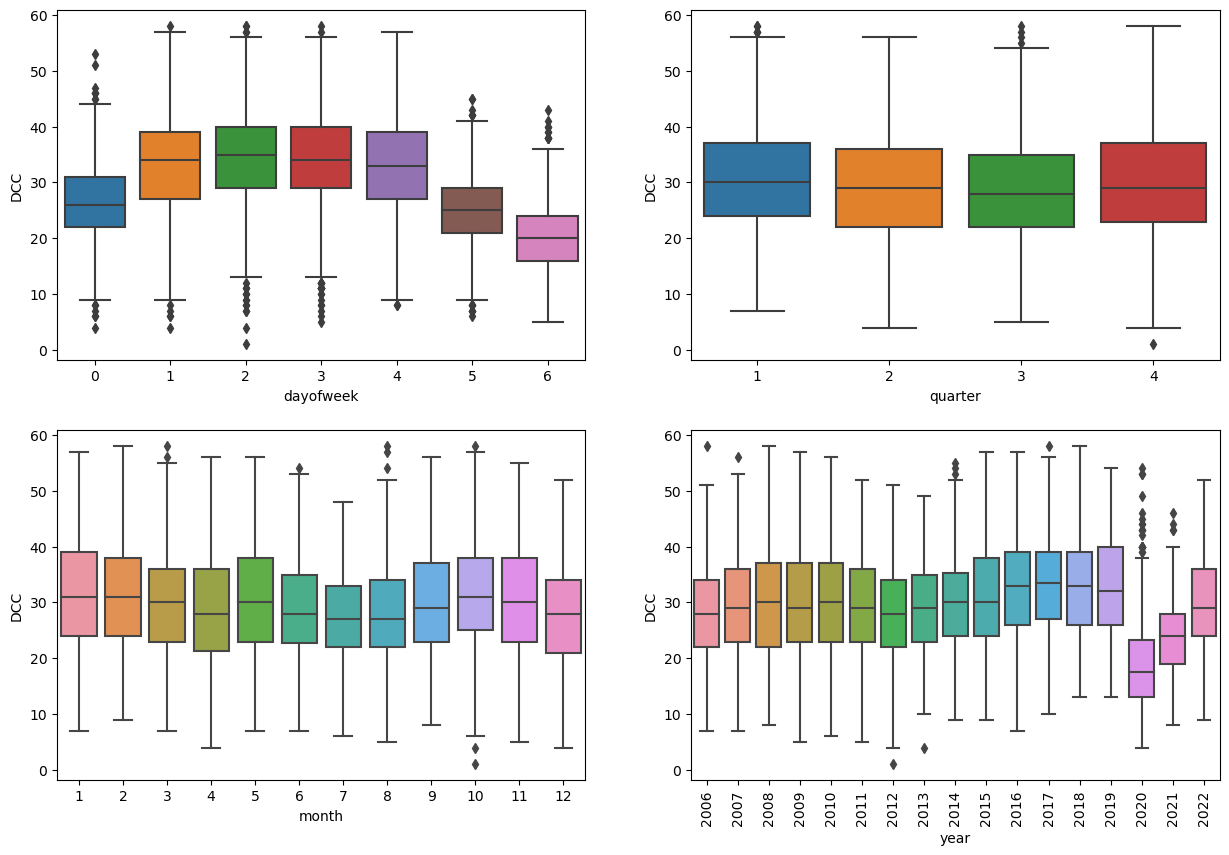

In [158]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df5_daily, x = 'dayofweek', y = 'DCC')
ax.set_title('Complaint Count by Day of the Week')

plt.subplot(2,2,2)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df5_daily, x = 'quarter', y = 'DCC')
ax.set_title('Complaint Count by by Quarter')

plt.subplot(2,2,3)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df5_daily, x = 'month', y = 'DCC')
ax.set_title('Complaint Count by Month')

plt.subplot(2,2,4)
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df5_daily, x = 'year', y = 'DCC')
ax.set_title('Complaint Count by Year')
plt.xticks(rotation=90)

plt.show()

In [159]:
train = create_features1(train)
test = create_features1(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear']
TARGET = 'DCC' 

In [160]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [161]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set =[(X_train, y_train), (X_test, y_test)],
        verbose = 50)

[0]	validation_0-rmse:9.28573	validation_1-rmse:9.92817
[50]	validation_0-rmse:7.78586	validation_1-rmse:9.37901
[100]	validation_0-rmse:7.08427	validation_1-rmse:9.27187
[150]	validation_0-rmse:6.73274	validation_1-rmse:9.32186
[157]	validation_0-rmse:6.69075	validation_1-rmse:9.33170


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [162]:
fi = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

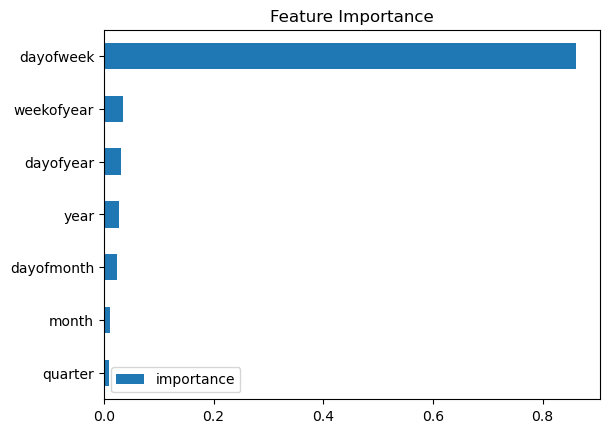

In [163]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.show()

In [164]:
#forecast on test set

test['prediction'] = reg.predict(X_test)

In [165]:
df5_daily = df5_daily.merge(test[['prediction']], how ='left', left_index = True, right_index = True)

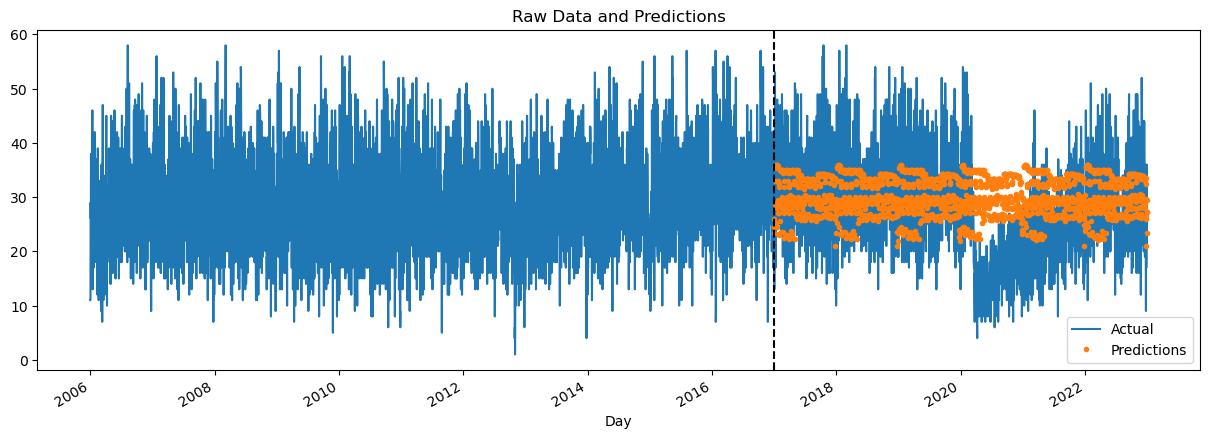

In [166]:
ax = df5_daily[['DCC']].plot(figsize=(15,5))
df5_daily['prediction'].plot(ax=ax, style = '.')
plt.legend(['Actual', 'Predictions'])
ax.set_title('Raw Data and Predictions')
ax.axvline('2016-12-31', color = 'black', ls = '--')
plt.show()

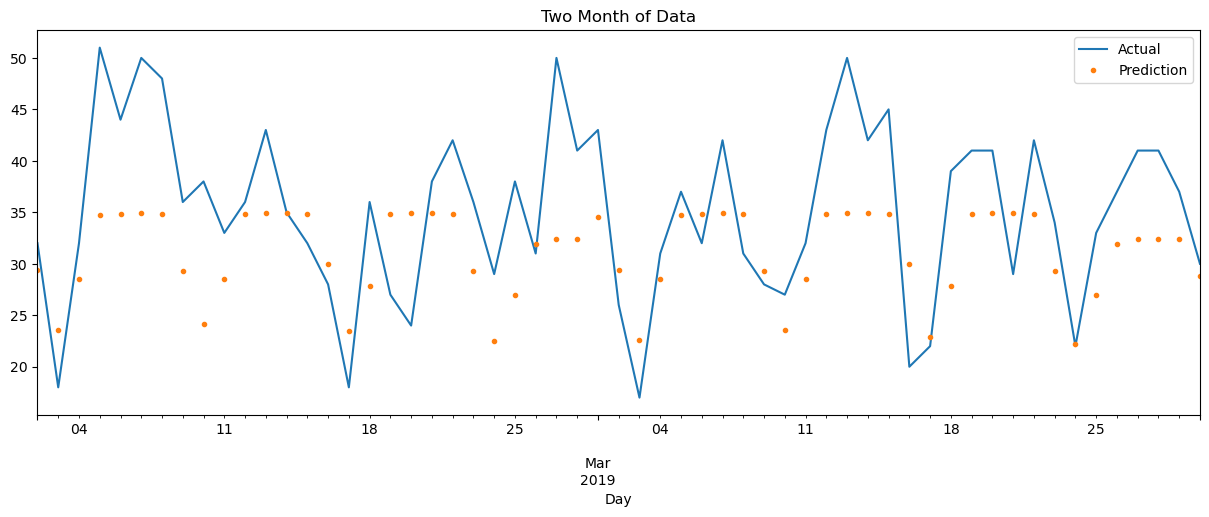

In [167]:
ax = df5_daily.loc[(df5_daily.index > '2019-02-01') & (df5_daily.index < '2019-03-31')]['DCC'].plot(figsize=(15,5), title = 'Two Month of Data')
df5_daily.loc[(df5_daily.index > '2019-02-01') & (df5_daily.index < '2019-03-31')]['prediction'].plot(style = '.')
plt.legend(['Actual', 'Prediction'])

plt.show()

In [168]:
rmse = np.sqrt(mean_squared_error(test['DCC'], test['prediction']))
print(f'RMSE Score on test set: {rmse:0.2f}')

RMSE Score on test set: 9.27


In [169]:
# Calculate Error - look at the worst and best predicted days

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2020-04-07    30.802441
2020-11-04    26.953403
2020-04-10    26.885998
2020-05-06    26.860695
2020-05-15    25.885998
Name: error, dtype: float64

In [170]:
print("Bottom 5 RMSE errors: ")
test.groupby('date')['error'].mean().sort_values(ascending=False).tail(5)

Bottom 5 RMSE errors: 


date
2021-12-13    0.029427
2021-05-24    0.025694
2017-04-24    0.012981
2022-04-25    0.012981
2021-07-05    0.007011
Name: error, dtype: float64

# Time Series Cross Validation
- Jan 1, 2006 through 12/31/2019, EXCLUDING COVID

In [171]:
tss = TimeSeriesSplit(n_splits=5, test_size=364)
df4_daily = df4_daily.sort_index()

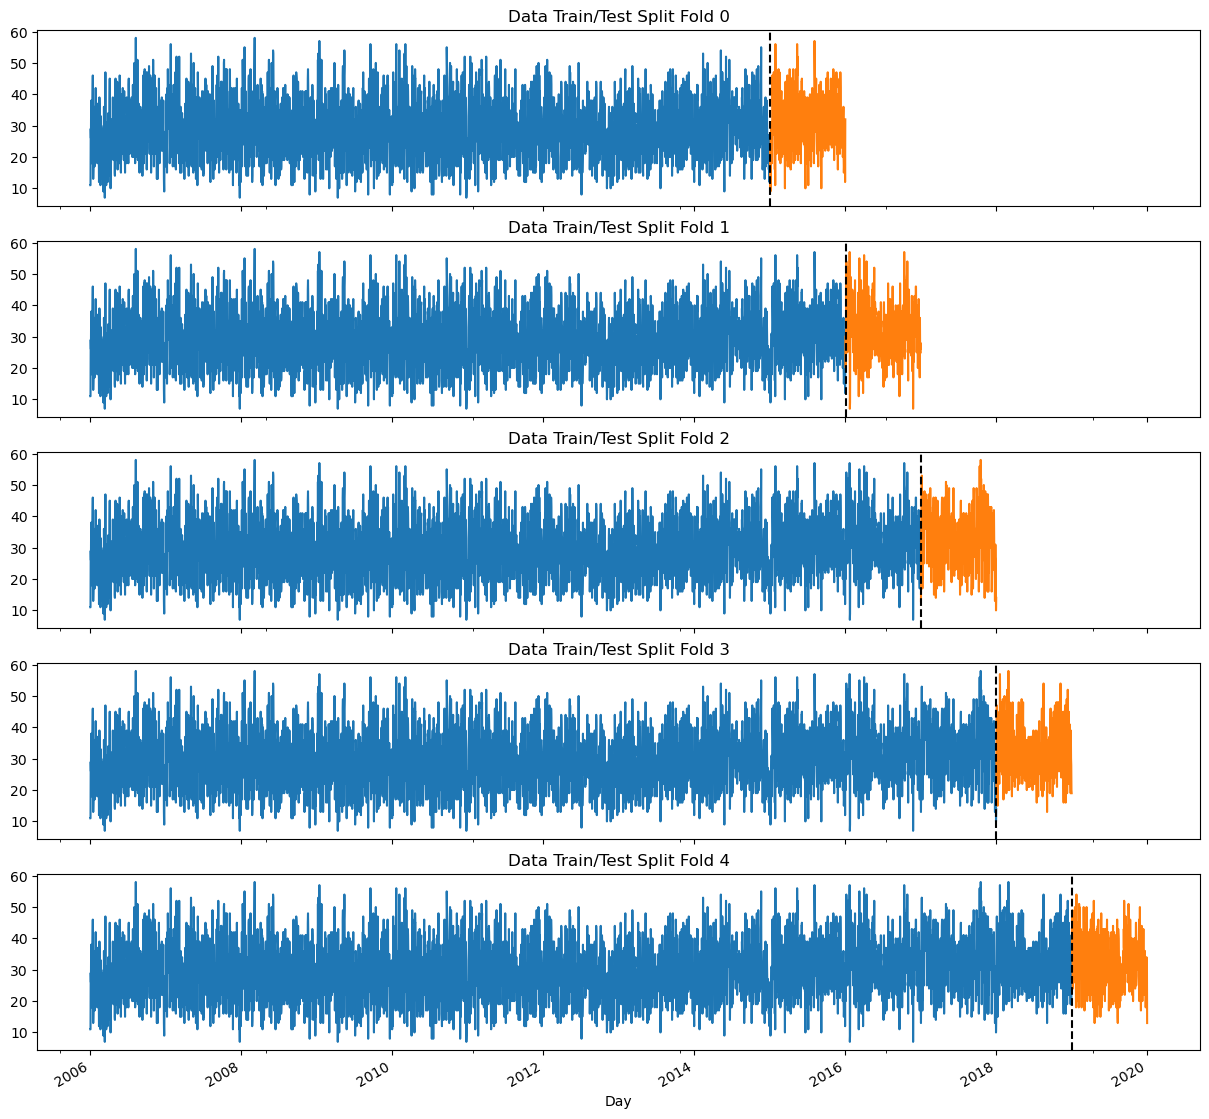

In [172]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold=0
for train_idx, val_idx in tss.split(df4_daily):
    train = df4_daily.iloc[train_idx]
    test = df4_daily.iloc[val_idx]
    train['DCC'].plot(ax=axs[fold],
                      label = 'Training Set',
                      title = f'Data Train/Test Split Fold {fold}')
    test['DCC'].plot(ax=axs[fold],
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls='--')
    fold += 1
plt.show()

for train_idx, val_idx in tss.split(df4_daily):
    break

In [173]:
def create_features2(df4_daily):
    
    df4_daily = df4_daily.copy()
    df4_daily['dayofweek'] = df4_daily.index.dayofweek
    df4_daily['quarter'] = df4_daily.index.quarter
    df4_daily['month'] = df4_daily.index.month
    df4_daily['year'] = df4_daily.index.year
    df4_daily['dayofyear'] = df4_daily.index.dayofyear
    df4_daily['dayofmonth'] = df4_daily.index.day
    df4_daily['weekofyear'] = df4_daily.index.isocalendar().week
    return df4_daily

df4_daily = create_features2(df4_daily)

In [174]:
def add_lags(df4_daily):
    target_map = df4_daily['DCC'].to_dict()
    df4_daily['lag1']=(df4_daily.index - pd.Timedelta('364 days')).map(target_map)
    df4_daily['lag2']=(df4_daily.index - pd.Timedelta('728 days')).map(target_map)
    df4_daily['lag3']=(df4_daily.index - pd.Timedelta('1092 days')).map(target_map)
    return df4_daily

In [175]:
df4_daily = add_lags(df4_daily)

In [176]:
df4_daily.tail()

DCC  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
Day                                                                       
2019-12-27   31          4        4     12  2019        361          27   
2019-12-28   34          5        4     12  2019        362          28   
2019-12-29   29          6        4     12  2019        363          29   
2019-12-30   33          0        4     12  2019        364          30   
2019-12-31   13          1        4     12  2019        365          31   

            weekofyear  prediction  lag1  lag2  lag3  
Day                                                   
2019-12-27          52   28.093752  30.0  26.0  28.0  
2019-12-28          52   20.585516  28.0  10.0  25.0  
2019-12-29          52   26.591696  20.0  14.0  13.0  
2019-12-30           1   17.355562  19.0  21.0  25.0  
2019-12-31           1   17.720806  43.0  32.0  36.0

### Train Using Cross Validation

In [177]:
tss = TimeSeriesSplit(n_splits=5, test_size=364)
df4_daily = df4_daily.sort_index()

folds = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df4_daily):
    train = df4_daily.iloc[train_idx]
    test = df4_daily.iloc[val_idx]
    
    train = create_features2(train)
    test = create_features2(test)
    
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    TARGET = 'DCC'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)], 
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:30.00924	validation_1-rmse:31.56763
[100]	validation_0-rmse:12.75334	validation_1-rmse:13.99352
[200]	validation_0-rmse:7.87556	validation_1-rmse:8.76060
[300]	validation_0-rmse:6.85941	validation_1-rmse:7.48284
[400]	validation_0-rmse:6.61670	validation_1-rmse:7.14543
[500]	validation_0-rmse:6.52019	validation_1-rmse:7.04495
[600]	validation_0-rmse:6.46115	validation_1-rmse:7.01196
[700]	validation_0-rmse:6.40945	validation_1-rmse:6.99154
[800]	validation_0-rmse:6.35468	validation_1-rmse:6.95767
[900]	validation_0-rmse:6.30868	validation_1-rmse:6.95012
[999]	validation_0-rmse:6.26781	validation_1-rmse:6.94440
[0]	validation_0-rmse:30.16756	validation_1-rmse:33.11413
[100]	validation_0-rmse:12.80930	validation_1-rmse:15.36453
[200]	validation_0-rmse:7.90276	validation_1-rmse:9.81114
[300]	validation_0-rmse:6.88652	validation_1-rmse:8.27744
[400]	validation_0-rmse:6.64750	validation_1-rmse:7.75995
[500]	validation_0-rmse:6.54461	validation_1-rmse:7.59020
[600]	vali

In [178]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 6.9667
Fold scores: [6.9444008616642305, 7.477568151313282, 6.833828512399432, 6.802627098343365, 6.775081867440175]


#### Future Predictions

In [179]:
df4_daily = create_features2(df4_daily)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'DCC'

X_all = df4_daily[FEATURES]
y_all = df4_daily[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=800,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:31.06213
[100]	validation_0-rmse:13.14027
[200]	validation_0-rmse:8.02830
[300]	validation_0-rmse:6.96069
[400]	validation_0-rmse:6.71839
[500]	validation_0-rmse:6.62994
[600]	validation_0-rmse:6.57705
[700]	validation_0-rmse:6.52407
[799]	validation_0-rmse:6.47980


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [180]:
df4_daily.index.max()

Timestamp('2019-12-31 00:00:00')

In [181]:
future = pd.date_range('2020-01-30', '2022-12-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df4_daily['isFuture'] = False
df_and_future = pd.concat([df4_daily, future_df])
df_and_future = create_features2(df_and_future)
df_and_future = add_lags(df_and_future)

In [182]:
future_w_features = df_and_future.query('isFuture').copy()

#### Make Predictions

In [183]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

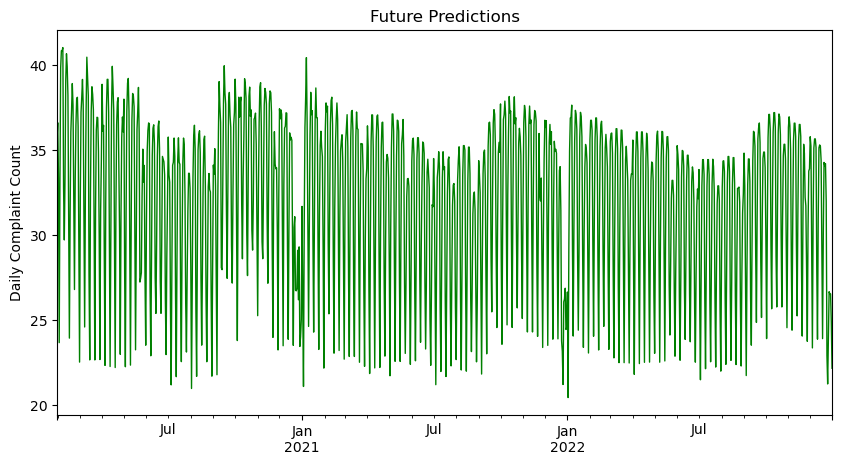

In [184]:
future_w_features['pred'].plot(figsize=(10,5),
                               color= 'green',
                               ms=1,
                               lw=1,
                               title='Future Predictions', ylabel = 'Daily Complaint Count')
plt.show()